## Setup

In [2]:
# Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Print multiple outputs per cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [3]:
def score_model(model, x_train, y_train, x_test, y_test):
        ## Score for training data set
        y_pred_train = model.predict(x_train)

        print("#### Training dataset scores ####")
        try:
            print(f"The intercept for model is {model.intercept_:.4f}")
        except:
            pass
        print(f'Mean Absolute Error: {mean_absolute_error(y_train, y_pred_train):.6f}')  
        print(f'Mean Squared Error: {mean_squared_error(y_train, y_pred_train):.6f}')  
        print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.6f}')
        print(f'R2 score: {model.score(x_train, y_train):.6f}')
        print()

        ## Score for testing data set
        y_pred_test = model.predict(x_test)

        print("#### Testing dataset scores ####")
        try:
            print(f"The intercept for model is {model.intercept_:.4f}")
        except:
            pass
        print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred_test):.6f}')  
        print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred_test):.6f}')  
        print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.6f}')
        print(f'R2 score: {model.score(x_test, y_test):.6f}')

## Merged Dataset Creation

In [4]:
#### Top 5 Countries: United States, China, Japan, Germany, India ####
debug=True

keep_countries = ["United States", "China", "Japan", "Germany", "India"]
keep_metrics = ["country", "year", "co2", "population", "gdp", "primary_energy_consumption"]

# Import main co2 dataset
co2 = pd.read_csv("data/owid-co2-data.csv")

co2 = co2[keep_metrics]

if debug:
    co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25204 entries, 0 to 25203
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     25204 non-null  object 
 1   year                        25204 non-null  int64  
 2   co2                         23949 non-null  float64
 3   population                  22878 non-null  float64
 4   gdp                         13538 non-null  float64
 5   primary_energy_consumption  8690 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.2+ MB


In [5]:
co2 = co2[co2["country"].isin(keep_countries)]

if debug:
    display(co2.sample(10))

,country,year,co2,population,gdp,primary_energy_consumption
9520,Germany,1950,510.682,69966252.0,4.229651e+11,NaN
10898,India,1941,53.654,394407406.0,4.312617e+11,NaN
4641,China,1938,55.303,515194677.0,5.148760e+11,NaN
10881,India,1924,40.680,327657673.0,3.518537e+11,NaN
11954,Japan,1938,131.735,70368151.0,3.059775e+11,NaN
23983,United States,1936,1713.350,134216250.0,1.359902e+12,NaN
9582,Germany,2012,813.985,80972629.0,3.536438e+12,3713.573
24014,United States,1967,3705.254,203905081.0,4.538980e+12,15919.950
11950,Japan,1934,101.203,66857121.0,2.557248e+11,NaN
11906,Japan,1890,6.756,39847686.0,7.428574e+10,NaN


In [6]:
#  Load Coal Production Dataset

coal = pd.read_csv("data/coal-production-by-region.csv")
coal = coal.drop(["Code"], axis=1)

if debug:
    coal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Entity                 1762 non-null   object 
 1   Year                   1762 non-null   int64  
 2   Coal Production - TWh  1762 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 41.4+ KB


In [7]:
coal = coal[coal["Entity"].isin(keep_countries)]
coal = coal.rename(columns={"Entity": "country", "Year": "year"})

if debug:
    display(coal.sample(10))

,country,year,Coal Production - TWh
610,India,1991,1321.824157
700,Japan,2001,19.300217
608,India,1989,1147.427299
683,Japan,1984,108.360664
1538,United States,1993,5661.802275
291,China,1992,6491.749700
482,Germany,1983,1642.870590
634,India,2015,3268.103053
607,India,1988,1055.135537
1562,United States,2017,4350.378661


In [8]:
co2_coal = pd.merge(co2, coal, on=["country", "year"], how="outer")

if debug:
    co2_coal.info()
    display(co2_coal.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 887
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     888 non-null    object 
 1   year                        888 non-null    int64  
 2   co2                         875 non-null    float64
 3   population                  880 non-null    float64
 4   gdp                         724 non-null    float64
 5   primary_energy_consumption  275 non-null    float64
 6   Coal Production - TWh       200 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 55.5+ KB


,country,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh
202,Germany,1872,92.109,40296219.0,1.221689e+11,NaN,NaN
480,India,1987,455.759,819682095.0,1.412884e+12,1793.763,992.484298
695,United States,1828,1.594,12522641.0,3.686085e+10,NaN,NaN
276,Germany,1946,271.682,70224410.0,2.285721e+11,NaN,NaN
29,China,1928,34.108,487927695.0,NaN,NaN,NaN
544,Japan,1898,17.246,42936456.0,9.633651e+10,NaN,NaN
718,United States,1851,24.633,24334712.0,9.221132e+10,NaN,NaN
845,United States,1978,4941.142,225223307.0,6.518624e+12,21246.981,NaN
577,Japan,1931,77.904,64324264.0,2.165335e+11,NaN,NaN
763,United States,1896,480.882,72859236.0,4.899914e+11,NaN,NaN


In [9]:
# Load Oil Consumption

oil = pd.read_csv("data/oil-consumption-by-country.csv")
oil = oil.drop(["Code"], axis=1)

if debug:
    oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5003 entries, 0 to 5002
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Entity                 5003 non-null   object 
 1   Year                   5003 non-null   int64  
 2   Oil Consumption - TWh  5003 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 117.4+ KB


In [10]:
oil = oil[oil["Entity"].isin(keep_countries)]
oil = oil.rename(columns={"Entity": "country", "Year": "year"})

if debug:
    display(oil.sample(10))

,country,year,Oil Consumption - TWh
1923,India,2019,2774.392986
2275,Japan,1979,3155.786492
1893,India,1989,667.772645
890,China,2005,3886.774544
1871,India,1967,169.360228
1598,Germany,1974,1748.524241
1589,Germany,1965,1020.569777
2265,Japan,1969,1948.934828
855,China,1970,332.045548
4742,United States,2020,9038.974147


In [11]:
co2_coal_oil = pd.merge(co2_coal, oil, on=["country", "year"], how="outer")

if debug:
    co2_coal_oil.info()
    display(co2_coal_oil.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 887
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     888 non-null    object 
 1   year                        888 non-null    int64  
 2   co2                         875 non-null    float64
 3   population                  880 non-null    float64
 4   gdp                         724 non-null    float64
 5   primary_energy_consumption  275 non-null    float64
 6   Coal Production - TWh       200 non-null    float64
 7   Oil Consumption - TWh       280 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 62.4+ KB


,country,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh
331,Germany,2001,916.649,81453894.0,2.819463e+12,4044.479,677.528035,1590.963400
706,United States,1839,5.518,16991513.0,5.939015e+10,NaN,NaN,NaN
214,Germany,1884,157.526,45523375.0,1.554657e+11,NaN,NaN,NaN
887,United States,2020,4712.771,331002647.0,NaN,NaN,2976.323067,9038.974147
703,United States,1836,4.730,15634125.0,5.466030e+10,NaN,NaN,NaN
781,United States,1914,1317.980,102001413.0,9.051345e+11,NaN,NaN,NaN
52,China,1951,102.115,569909108.0,5.296060e+11,NaN,NaN,NaN
264,Germany,1934,408.620,68179764.0,4.084154e+11,NaN,NaN,NaN
800,United States,1933,1348.842,131426486.0,1.015525e+12,NaN,NaN,NaN
537,Japan,1891,8.123,40207610.0,7.065438e+10,NaN,NaN,NaN


In [12]:
# Load Coal Consumption Dataset

coal_cons = pd.read_csv('data/world-coal-consumption-1978-2020.csv')

# Comment out this line to include EU27 countries
coal_cons = coal_cons.drop(["EU27"], axis=1)
    
coal_cons = pd.melt(coal_cons, id_vars=["Year"], var_name="country", value_name="Coal Consumption - TWh")
coal_cons = coal_cons.rename(columns={"Year": "year"})

# Dataset gave values in Terajoules (supposedly??), converting to TWh
coal_cons["Coal Consumption - TWh"] = coal_cons["Coal Consumption - TWh"] / 3600

coal_cons.sample(10)

,year,country,Coal Consumption - TWh
94,1986,United States,4.803641
58,1993,India,1.284748
6,1984,China,4.463375
157,2006,Japan,1.298607
96,1988,United States,5.270374
29,2007,China,17.182822
152,2001,Japan,1.163130
80,2015,India,4.360651
9,1987,China,5.072229
57,1992,India,1.224084


In [13]:
merged = pd.merge(co2_coal_oil, coal_cons, on=["country", "year"], how="outer")

if debug:
    merged.info()
    display(merged.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 887
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     888 non-null    object 
 1   year                        888 non-null    int64  
 2   co2                         875 non-null    float64
 3   population                  880 non-null    float64
 4   gdp                         724 non-null    float64
 5   primary_energy_consumption  275 non-null    float64
 6   Coal Production - TWh       200 non-null    float64
 7   Oil Consumption - TWh       280 non-null    float64
 8   Coal Consumption - TWh      172 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 69.4+ KB


,country,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh
758,United States,1891,427.425,66079404.0,4.400794e+11,NaN,NaN,NaN,NaN
810,United States,1943,2271.985,143884915.0,2.203245e+12,NaN,NaN,NaN,NaN
630,Japan,1984,937.070,121189269.0,2.826577e+12,4421.824,108.360664,2643.381210,0.835557
313,Germany,1983,1011.605,77770210.0,1.784299e+12,4009.860,1642.870590,1482.448097,NaN
167,Germany,1837,5.950,30171030.0,NaN,NaN,NaN,NaN,NaN
777,United States,1910,1271.582,95863718.0,8.939754e+11,NaN,NaN,NaN,NaN
205,Germany,1875,101.518,41598517.0,1.376593e+11,NaN,NaN,NaN,NaN
315,Germany,1985,1044.118,77691591.0,1.874770e+12,4278.250,1728.615479,1522.741267,NaN
696,United States,1829,1.795,12879737.0,3.656867e+10,NaN,NaN,NaN,NaN
290,Germany,1960,813.950,73414229.0,8.902100e+11,NaN,NaN,NaN,NaN


In [14]:
# Load Coal Consumption Dataset

cars = pd.read_csv('data/car_production.csv')

cars = pd.melt(cars, id_vars=["country"], var_name="year", value_name="Cars Produced - Thousands")
cars["year"] = pd.to_numeric(cars["year"])  

if debug:
    cars.info()
    display(cars.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   country                    155 non-null    object
 1   year                       155 non-null    int64 
 2   Cars Produced - Thousands  155 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.8+ KB


,country,year,Cars Produced - Thousands
117,India,2013,3896.088
17,India,1991,355.0
72,India,2004,1511.171
35,China,1997,1578.0
41,Germany,1998,5727.0
106,Germany,2011,6311.318
20,China,1994,1353.0
95,China,2009,13648.553
138,Japan,2017,9690.201
10,China,1981,U


In [15]:
final = pd.merge(merged, cars, on=["country", "year"], how="outer")

if debug:
    final.info()
    display(final.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 887
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     888 non-null    object 
 1   year                        888 non-null    int64  
 2   co2                         875 non-null    float64
 3   population                  880 non-null    float64
 4   gdp                         724 non-null    float64
 5   primary_energy_consumption  275 non-null    float64
 6   Coal Production - TWh       200 non-null    float64
 7   Oil Consumption - TWh       280 non-null    float64
 8   Coal Consumption - TWh      172 non-null    float64
 9   Cars Produced - Thousands   155 non-null    object 
dtypes: float64(7), int64(1), object(2)
memory usage: 76.3+ KB


,country,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh,Cars Produced - Thousands
309,Germany,1979,1117.888,78438171.0,1.741603e+12,4375.909,NaN,1949.952991,NaN,NaN
750,United States,1883,253.883,55118525.0,3.562330e+11,NaN,NaN,NaN,NaN,NaN
752,United States,1885,272.162,57744514.0,3.653988e+11,NaN,NaN,NaN,NaN,NaN
761,United States,1894,425.050,70088593.0,4.462210e+11,NaN,NaN,NaN,NaN,NaN
545,Japan,1899,17.272,43360172.0,9.181341e+10,NaN,NaN,NaN,NaN,NaN
593,Japan,1947,70.032,79543183.0,2.117767e+11,NaN,NaN,NaN,NaN,NaN
77,China,1976,1226.421,942685412.0,1.413711e+12,3866.910,NaN,919.186395,NaN,NaN
66,China,1965,500.286,724218970.0,8.961268e+11,1532.235,NaN,129.062536,NaN,NaN
224,Germany,1894,229.498,50827444.0,2.058201e+11,NaN,NaN,NaN,NaN,NaN
79,China,1978,1492.778,972205441.0,1.667552e+12,4624.290,NaN,1076.636878,3.570364,NaN


In [16]:
# Export

final.to_csv('dataset.csv', index=False) 

## Data Preparation

In [17]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 887
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     888 non-null    object 
 1   year                        888 non-null    int64  
 2   co2                         875 non-null    float64
 3   population                  880 non-null    float64
 4   gdp                         724 non-null    float64
 5   primary_energy_consumption  275 non-null    float64
 6   Coal Production - TWh       200 non-null    float64
 7   Oil Consumption - TWh       280 non-null    float64
 8   Coal Consumption - TWh      172 non-null    float64
 9   Cars Produced - Thousands   155 non-null    object 
dtypes: float64(7), int64(1), object(2)
memory usage: 76.3+ KB


In [18]:
final.isna().sum()

country                         0
year                            0
co2                            13
population                      8
gdp                           164
primary_energy_consumption    613
Coal Production - TWh         688
Oil Consumption - TWh         608
Coal Consumption - TWh        716
Cars Produced - Thousands     733
dtype: int64

In [19]:
final.describe()

,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh
count,888.000000,875.000000,8.800000e+02,7.240000e+02,275.000000,200.000000,280.000000,172.000000
mean,1926.950450,988.530721,2.677760e+08,2.140407e+12,9645.127495,4147.882140,3464.591754,5.035815
std,58.852728,1744.578106,3.421499e+08,3.459539e+12,9373.407894,5364.788045,3314.434887,5.743050
min,1792.000000,0.011000,6.000000e+06,2.668967e+10,616.017000,4.893107,129.062536,0.444705
25%,1884.750000,28.587000,5.082469e+07,2.566350e+11,3729.211500,542.562560,1297.874098,1.280155
50%,1932.000000,220.712000,1.049918e+08,6.152506e+11,4856.292000,1782.474436,1991.874998,3.839166
75%,1976.000000,1045.795000,3.280095e+08,2.535874e+12,15859.317500,6062.563019,4226.491485,5.834072
max,2020.000000,10667.887000,1.439324e+09,1.815162e+13,39360.925000,22475.080114,11214.078236,24.343903


## Fix Missing Data

#### We used 4 different ways to impute missing values and the 4th option is the best
#### 4th option uses data after 1950 and has less missing values
#### Correleation plots and box plots for all 4 options were generated and both correleation plot and box plot for option 4 show better results

####  Option 4 is used to do all the analysis and for ML

#### We were not able to use co2 variable to generate category because there is a huge difference between interquartile range, 
#### instead rank function was used to rank co2 variable and interquartile range of ranked CO2 was generated and  3 categories were developed

#### Option 1
#### Interpolate with Linear Method in forward direction

In [20]:
option_1 = final.copy()
option_1 = option_1.interpolate(method="linear", limit_direction ='forward')
option_1.isnull().sum()

country                         0
year                            0
co2                             0
population                      0
gdp                             1
primary_energy_consumption     66
Coal Production - TWh          82
Oil Consumption - TWh          66
Coal Consumption - TWh         79
Cars Produced - Thousands     733
dtype: int64

In [21]:
option_1.describe()

,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh
count,888.000000,888.000000,8.880000e+02,8.870000e+02,822.000000,806.000000,822.000000,809.000000
mean,1926.950450,974.074128,2.719281e+08,2.214440e+12,10685.207618,4774.615764,3238.775775,7.362645
std,58.852728,1735.807802,3.450945e+08,3.653493e+12,9555.589054,5821.075541,2560.799160,6.908899
min,1792.000000,0.011000,6.000000e+06,2.668967e+10,616.017000,4.893107,129.062536,0.444705
25%,1884.750000,24.768750,5.141600e+07,2.319887e+11,3746.412818,670.375275,1312.043420,2.247800
50%,1932.000000,205.729500,1.080558e+08,5.280018e+11,7134.121160,2485.929892,2422.588984,3.980166
75%,1976.000000,1035.912500,3.348168e+08,2.565860e+12,13933.216909,6023.075255,4747.493041,11.643186
max,2020.000000,10667.887000,1.439324e+09,1.815162e+13,39360.925000,22475.080114,11214.078236,24.343903


In [22]:
option_1.fillna(0, inplace=True)

#### Option 2
#### Interpolate with Linear Method both directions

In [23]:
option_2 = final.copy()
option_2 = option_2.interpolate(method="linear", limit_direction ='both')

In [24]:
option_2.isna().sum()

country                         0
year                            0
co2                             0
population                      0
gdp                             0
primary_energy_consumption      0
Coal Production - TWh           0
Oil Consumption - TWh           0
Coal Consumption - TWh          0
Cars Produced - Thousands     733
dtype: int64

In [25]:
option_2.fillna(0, inplace=True)

#### Option 3
#### Using Simpleimputer to impute missing values

In [26]:
option_3 = final.copy()

In [27]:
categorical_list = []
numerical_list = []

for i in option_3.columns.tolist():
    if option_3[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
        
print(f'Number of numerical features: {str(len(numerical_list))}')
print(f'Number of categorical features: {str(len(categorical_list))}')

Number of numerical features: 8
Number of categorical features: 2


In [28]:
from sklearn.impute import SimpleImputer

option_3[numerical_list] = SimpleImputer(strategy='median').fit_transform(option_3[numerical_list])
option_3.isna().sum()

country                         0
year                            0
co2                             0
population                      0
gdp                             0
primary_energy_consumption      0
Coal Production - TWh           0
Oil Consumption - TWh           0
Coal Consumption - TWh          0
Cars Produced - Thousands     733
dtype: int64

In [29]:
## Inspecting missing values for Cars Produced

option_3[option_3["Cars Produced - Thousands"].isnull()][:20]

,country,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh,Cars Produced - Thousands
0,China,1899.0,0.095,399421783.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
1,China,1900.0,220.712,401579661.0,3.888000e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
2,China,1901.0,220.712,403786465.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
3,China,1902.0,0.095,406042669.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
4,China,1903.0,1.964,408348748.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
5,China,1904.0,2.088,410667922.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
6,China,1905.0,2.297,413000265.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
7,China,1906.0,17.111,415345852.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
8,China,1907.0,16.840,417704759.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN
9,China,1908.0,22.731,420077060.0,6.152506e+11,4856.292,1782.474436,1991.874998,3.839166,NaN


In [30]:
option_3.fillna(0, inplace=True)

## Boxplots for select variables across Options 1-3

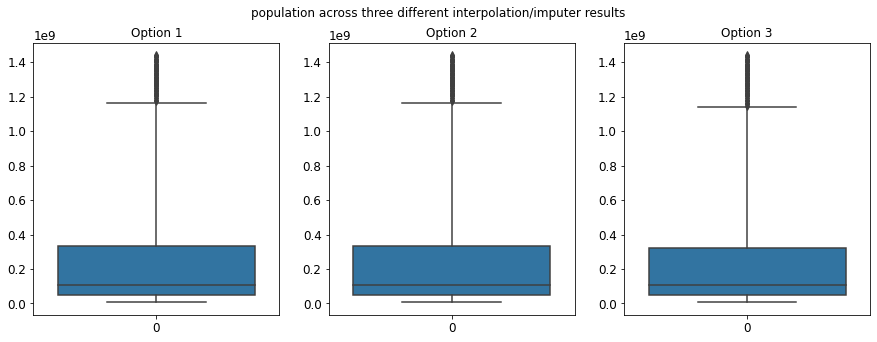

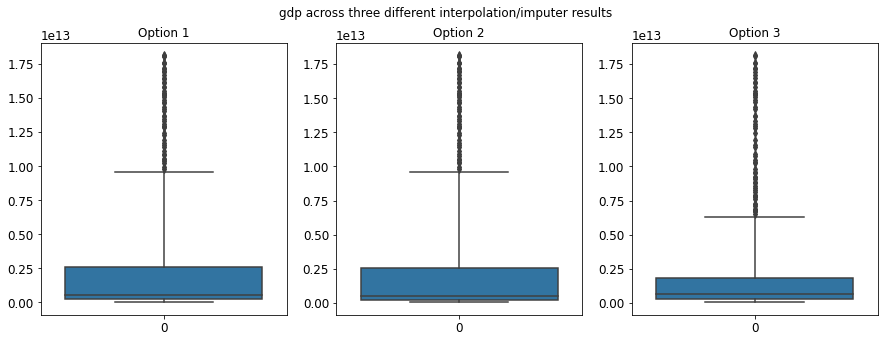

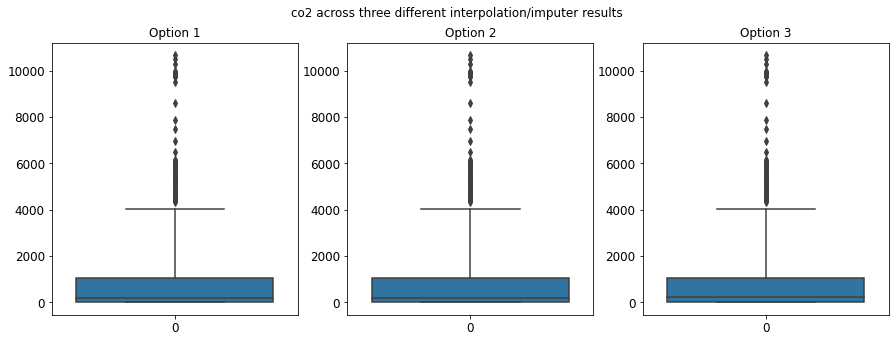

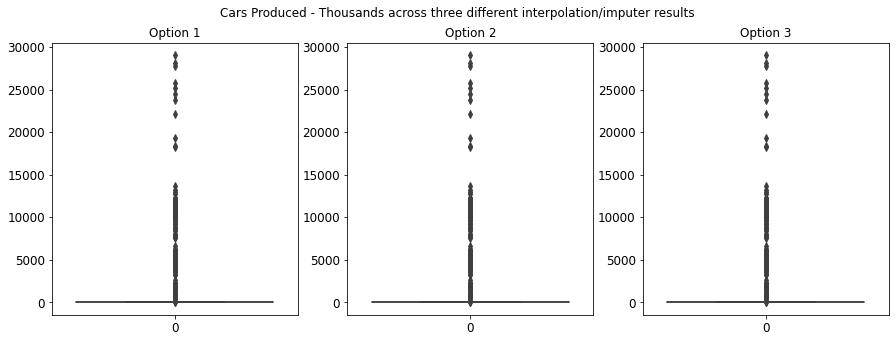

In [31]:
_vars = ['population', 'gdp', 'co2', 'Cars Produced - Thousands']

option_1 = option_1[option_1["Cars Produced - Thousands"] != 'U']
option_2 = option_2[option_2["Cars Produced - Thousands"] != 'U']
option_3 = option_3[option_3["Cars Produced - Thousands"] != 'U']

for i in _vars:
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
    fig.suptitle(f'{i} across three different interpolation/imputer results')

    sns.boxplot(ax=axes[0], data = option_1[i], whis=3)
    axes[0].set_title("Option 1")
    
    sns.boxplot(ax=axes[1], data = option_2[i], whis=3)
    axes[1].set_title("Option 2")
    
    sns.boxplot(ax=axes[2], data = option_3[i], whis=3)
    axes[2].set_title("Option 3");
    
    print()

### Correleation Heatmaps
#### Determining which option has the highest correlations

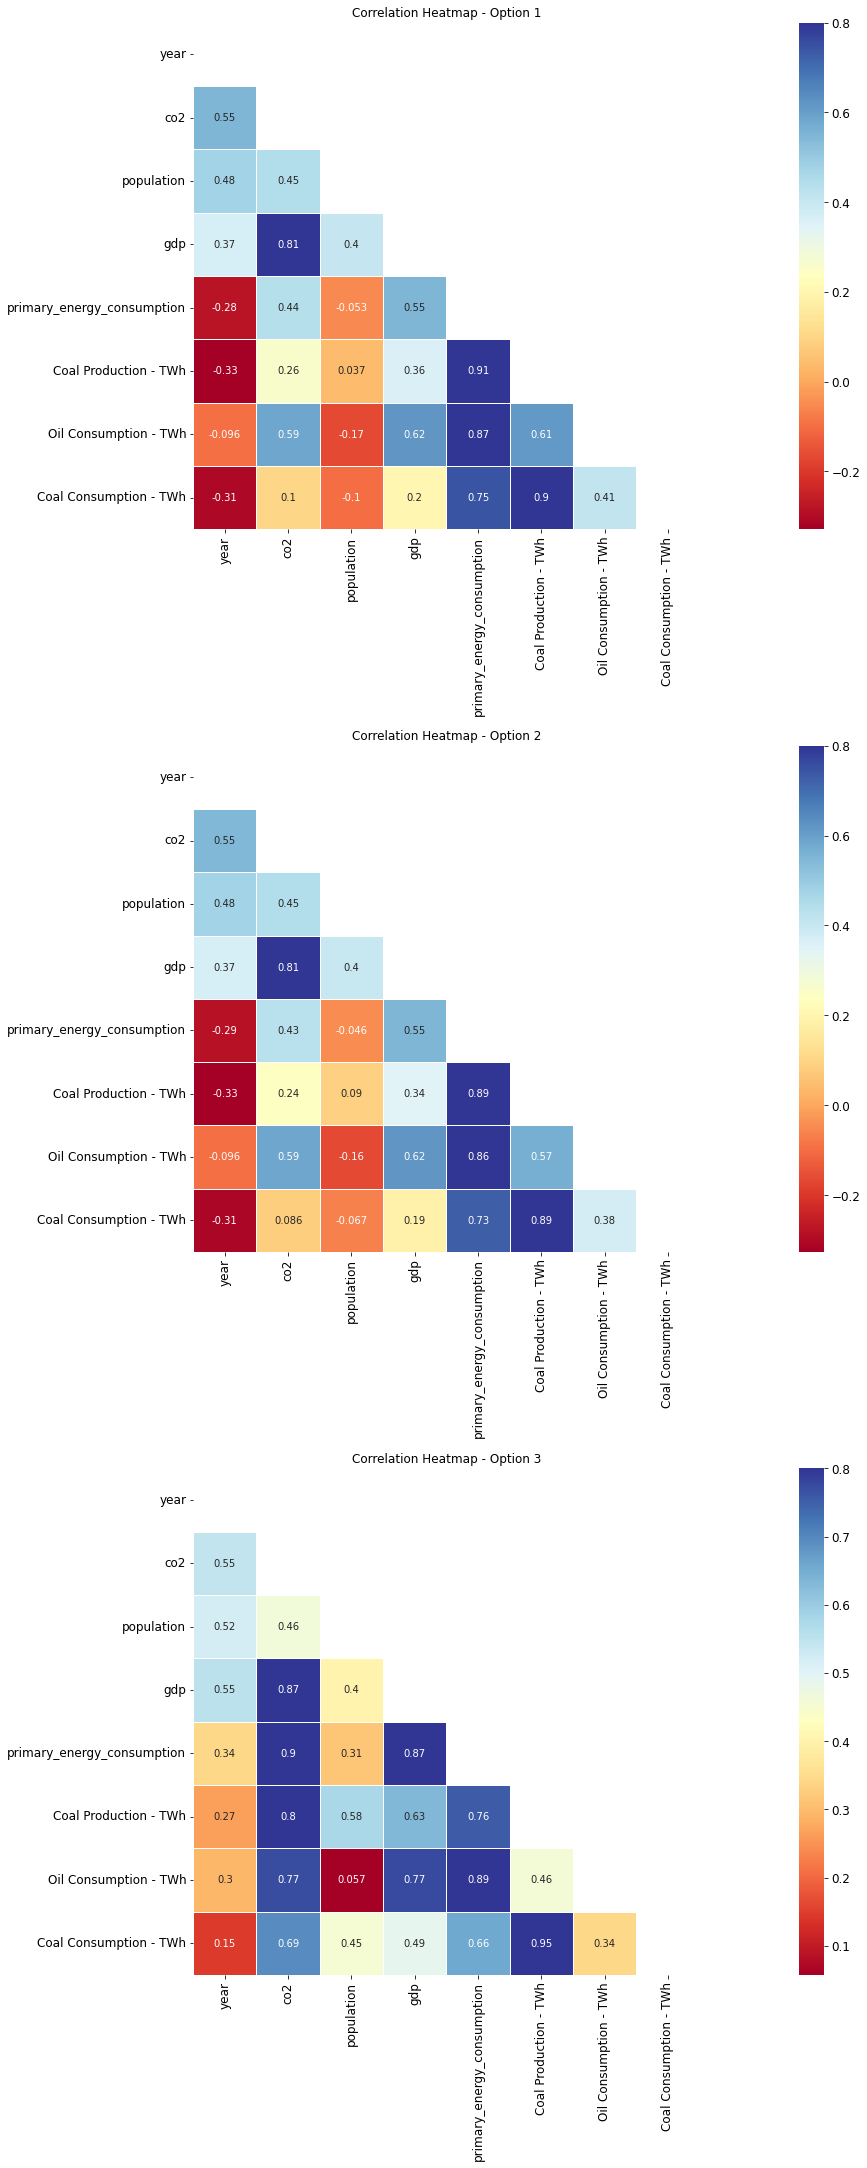

In [32]:
options = [option_1, option_2, option_3]

f, ax = plt.subplots(3, 1, figsize=(30,30), constrained_layout=True)

for i, opt in enumerate(options):
    cm = opt.corr()

    ## creating a mask to only see relationship between few variables
    mask= np.triu(np.ones_like(cm, dtype=bool))

    ## creating heat map using a mask
    sns.heatmap(cm, ax=ax[i], vmax=.8, square=True, mask = mask, annot=True, cmap='RdYlBu', linewidths=.9 )
    ax[i].set_title(f'Correlation Heatmap - Option {i+1}')

### Option 4 - Filtering data before 19XX

#### Much of the `null` values seem to come from years before 1950. We can iterate each decade and determine what year to start dropping data from.

In [33]:
decades = []

for i in range(1970, 1920, -10):
    tmp = final[final.year > i]
    decades.append(tmp)
    
    print(f'\n>{i}')
    display(tmp.isna().sum())
    print(f'\rTotal nulls: {tmp.isna().sum().sum()}')


>1970


country                         0
year                            0
co2                             0
population                      0
gdp                            10
primary_energy_consumption      5
Coal Production - TWh          50
Oil Consumption - TWh           0
Coal Consumption - TWh         78
Cars Produced - Thousands     100
dtype: int64

Total nulls: 243

>1960


country                         0
year                            0
co2                             0
population                      0
gdp                            10
primary_energy_consumption     25
Coal Production - TWh         100
Oil Consumption - TWh          20
Coal Consumption - TWh        128
Cars Produced - Thousands     145
dtype: int64

Total nulls: 428

>1950


country                         0
year                            0
co2                             0
population                      0
gdp                            10
primary_energy_consumption     75
Coal Production - TWh         150
Oil Consumption - TWh          70
Coal Consumption - TWh        178
Cars Produced - Thousands     195
dtype: int64

Total nulls: 678

>1940


country                         0
year                            0
co2                             0
population                      0
gdp                            19
primary_energy_consumption    125
Coal Production - TWh         200
Oil Consumption - TWh         120
Coal Consumption - TWh        228
Cars Produced - Thousands     245
dtype: int64

Total nulls: 937

>1930


country                         0
year                            0
co2                             0
population                      0
gdp                            21
primary_energy_consumption    175
Coal Production - TWh         250
Oil Consumption - TWh         170
Coal Consumption - TWh        278
Cars Produced - Thousands     295
dtype: int64

Total nulls: 1189


In [34]:
for dec in decades:
    dec.fillna(0, inplace=True)

C:\Users\mateusz\AppData\Local\Temp\ipykernel_4752\4290702021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec.fillna(0, inplace=True)


### Correleation Map shows that Option 4 has stronger correleation compared to others

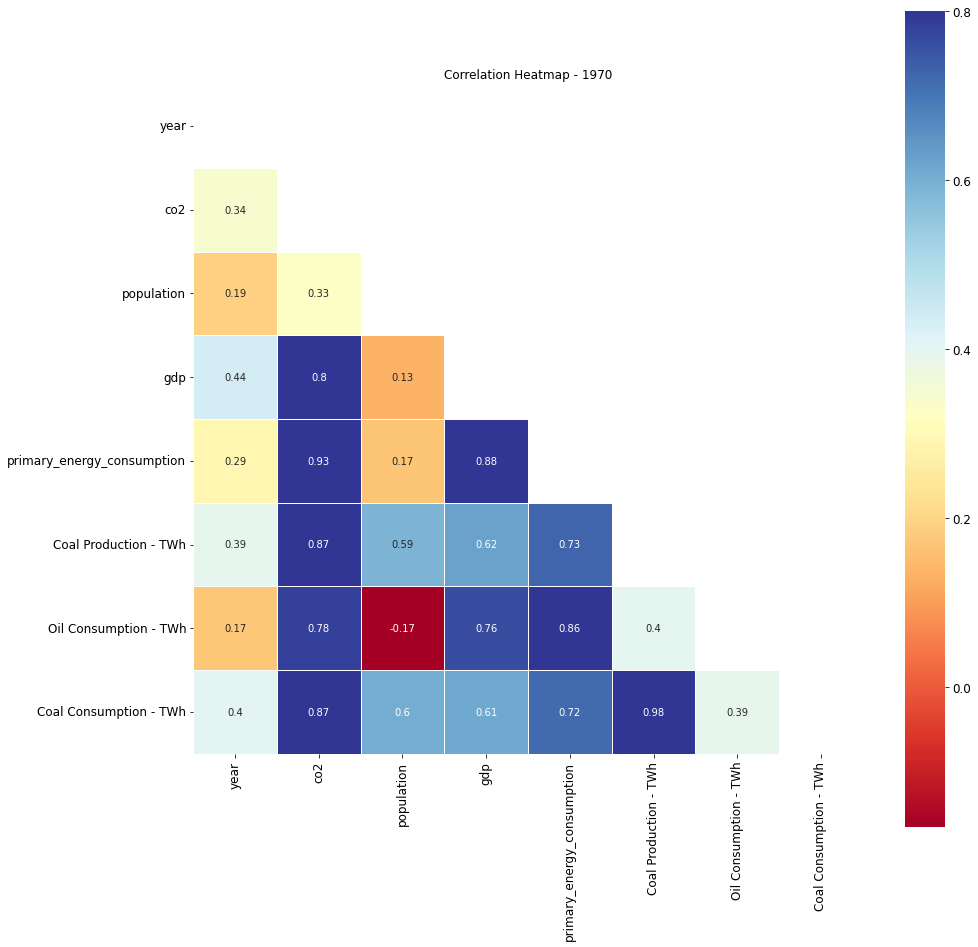

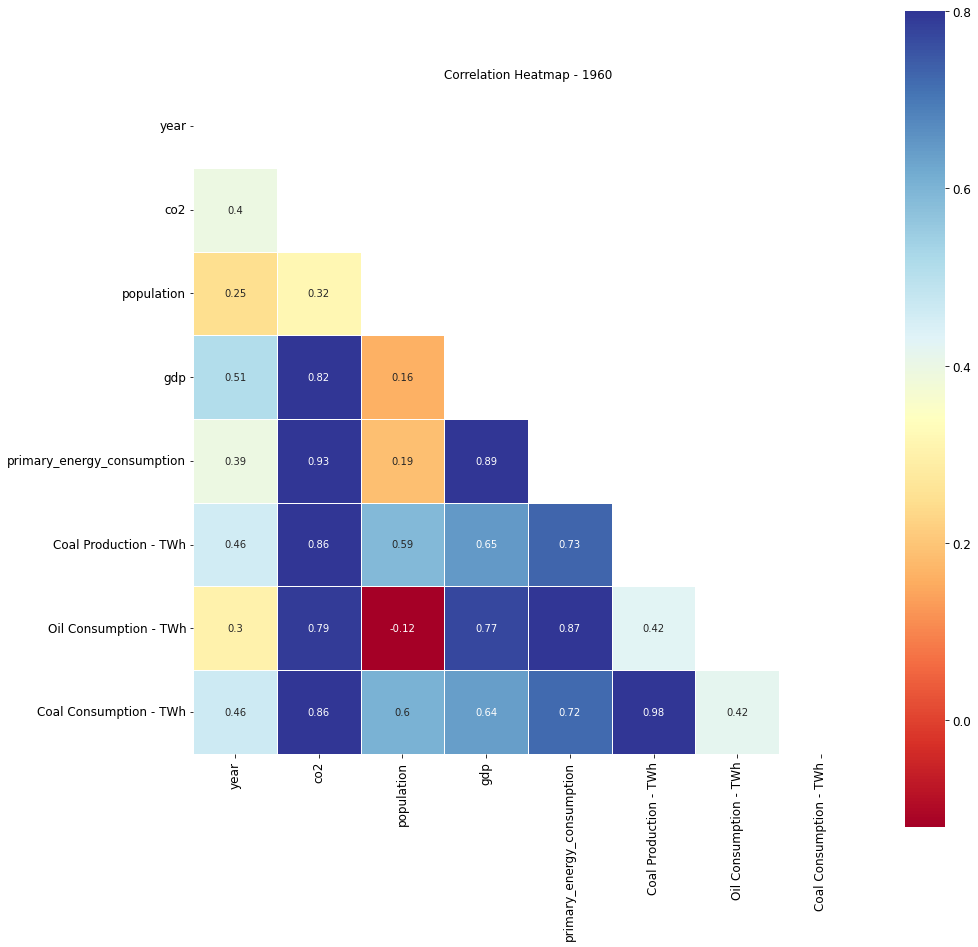

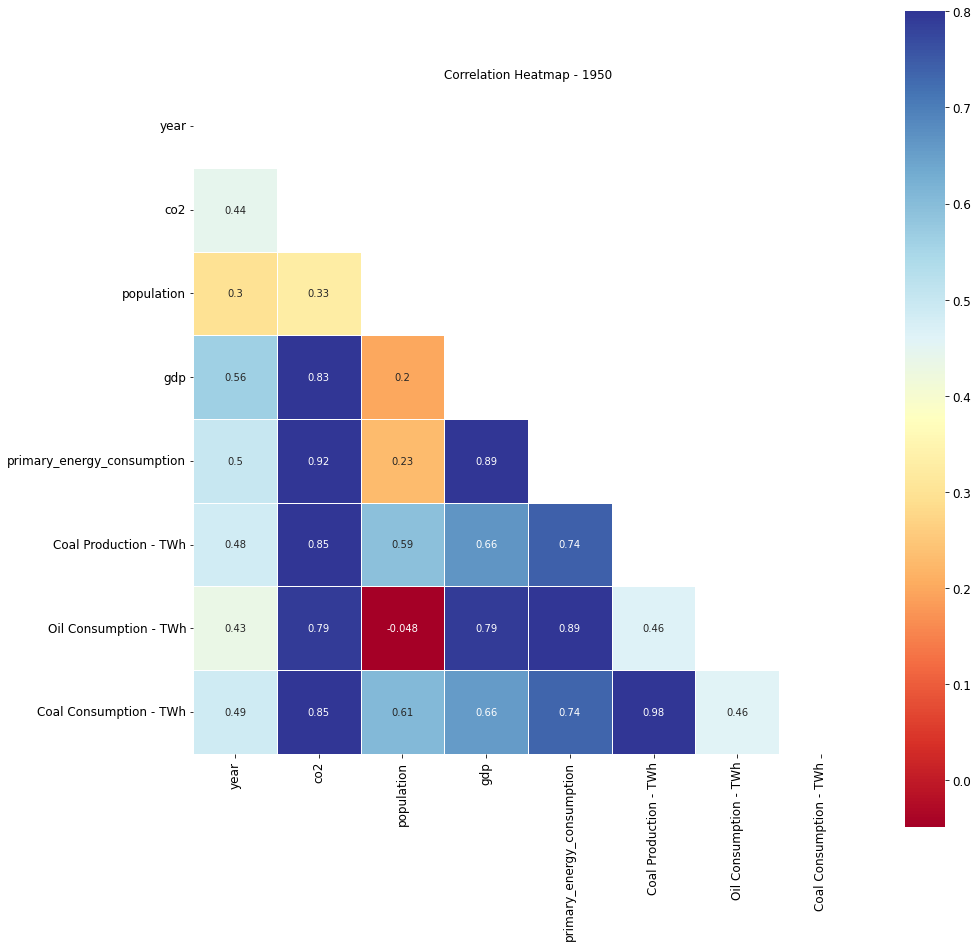

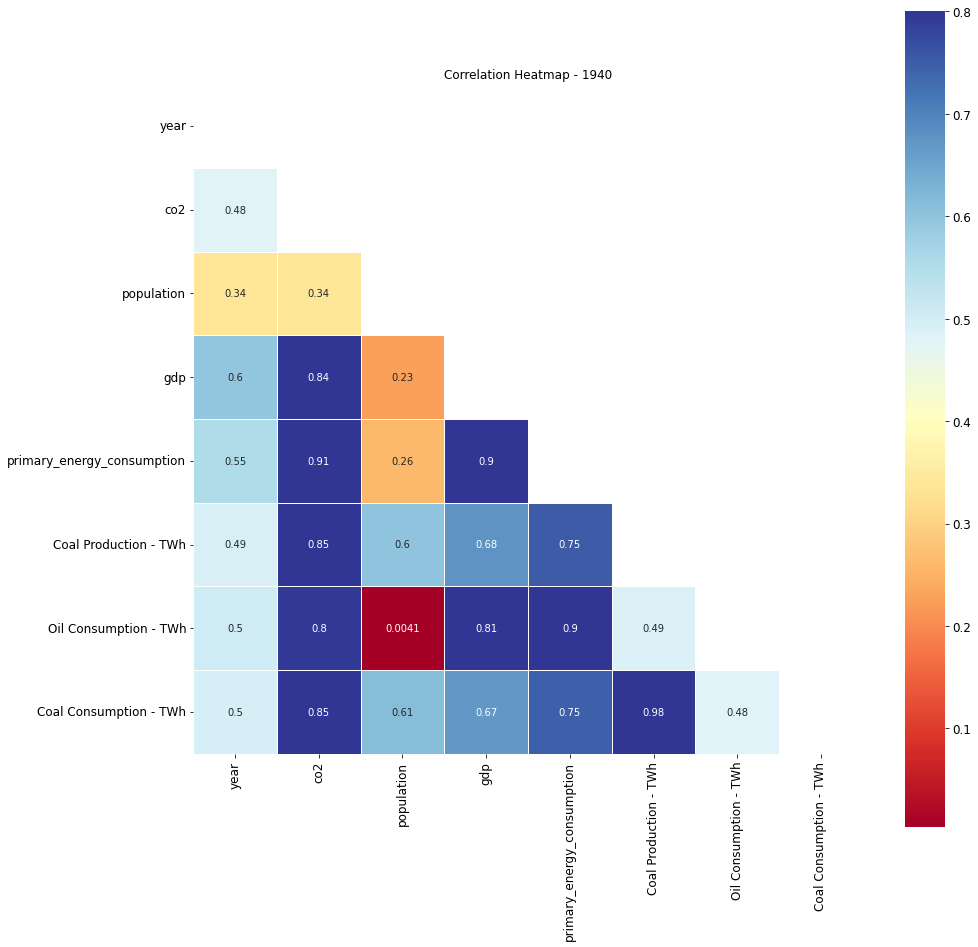

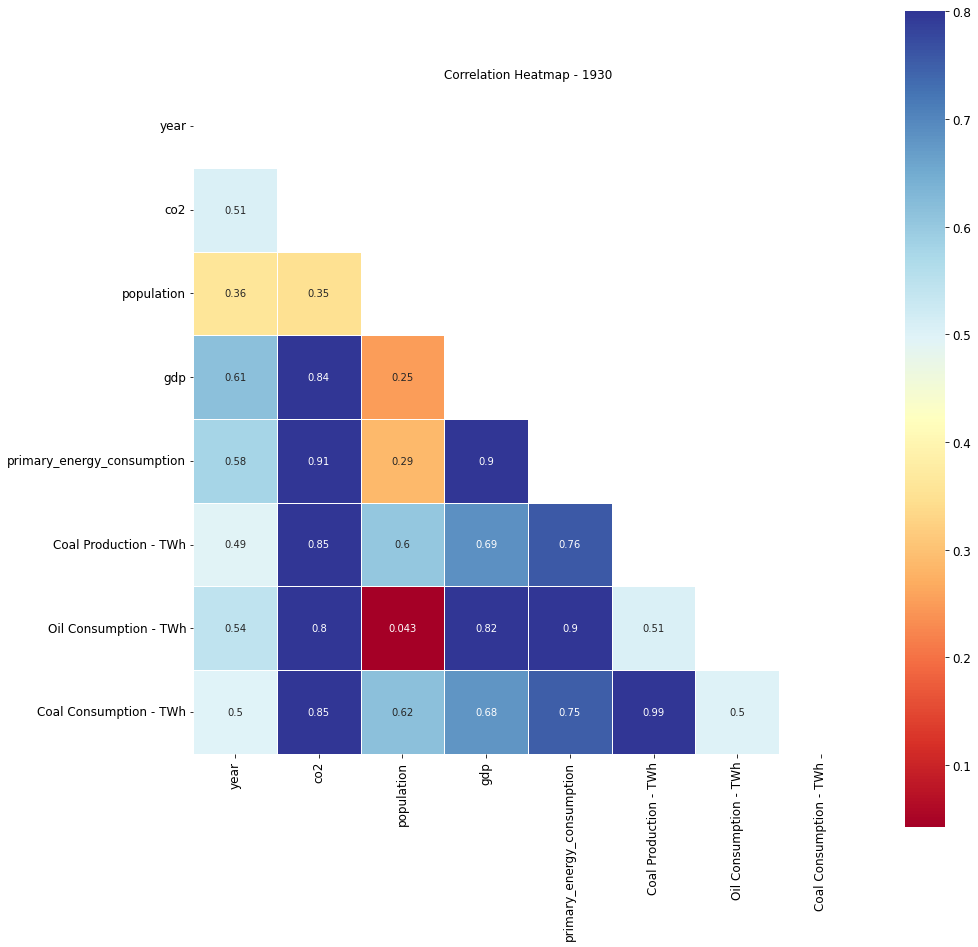

In [35]:
i = 1970

for df in decades:
    cm = df.corr()
    mask= np.triu(np.ones_like(cm, dtype=bool))

    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(cm, vmax=.8, square=True, mask = mask, annot=True, cmap='RdYlBu', linewidths=.9 )
    plt.title(f'Correlation Heatmap - {i}')
    i = i - 10


In [36]:
final_1950 = decades[2]

final_1950.reset_index().to_csv('final_1950.csv')

In [37]:
option_4 = final_1950.reset_index().copy()

#### Comparing Box Plots of option 4 with other three options

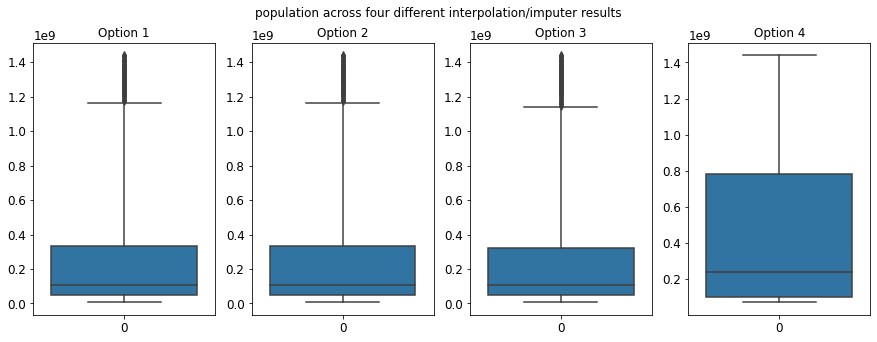

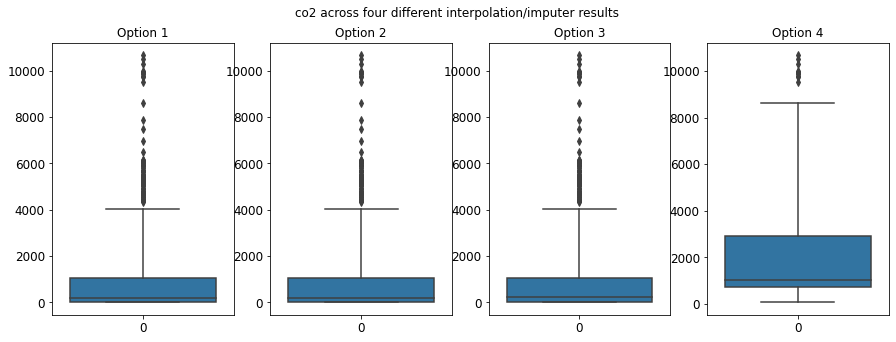

In [38]:
_vars = ['population', 'co2']

for i in _vars:
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(15,5))
    fig.suptitle(f'{i} across four different interpolation/imputer results')

    sns.boxplot(ax=axes[0], data = option_1[i], whis=3)
    axes[0].set_title("Option 1")
    
    sns.boxplot(ax=axes[1], data = option_2[i], whis=3)
    axes[1].set_title("Option 2")
    
    sns.boxplot(ax=axes[2], data = option_3[i], whis=3)
    axes[2].set_title("Option 3");
    
    sns.boxplot(ax=axes[3], data = option_4[i], whis=3)
    axes[3].set_title("Option 4");
    
    print()

### Inspecting CO2 variable for option 4 to see if there are truly outliers

#### Although the boxplot for CO2 shows outliers, this might be actual data becasue China is one of the worlds largest CO2 producers;  this finding makes sense

In [39]:
option_4[option_4["co2"] > 8000][:50]

,index,country,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh,Cars Produced - Thousands
59,111,China,2010,8616.653,1.368811e+09,1.285881e+13,28967.802,19367.248989,5275.544381,20.819195,18264.667
60,112,China,2011,9528.556,1.376498e+09,1.367316e+13,31261.361,21535.067208,5467.327189,22.674968,18418.876
61,113,China,2012,9775.622,1.384206e+09,1.435813e+13,32512.623,21789.302833,5731.219008,23.027610,19271.808
62,114,China,2013,9952.744,1.391883e+09,1.530443e+13,33715.209,22034.135553,5982.918831,23.743987,22116.825
63,115,China,2014,9985.583,1.399454e+09,1.622086e+13,34499.453,21680.762764,6218.294911,23.831354,23722.89
64,116,China,2015,9848.420,1.406848e+09,1.671095e+13,34826.942,21273.959439,6732.650186,23.311231,24503.326
65,117,China,2016,9720.444,1.414049e+09,1.725547e+13,35264.122,19671.231811,6961.925881,22.370055,28118.794
66,118,China,2017,9920.459,1.421022e+09,1.757508e+13,36342.177,20326.109319,7278.487461,22.720872,29015.633
67,119,China,2018,10289.990,1.427648e+09,1.815162e+13,37714.113,21352.949933,7517.874592,23.532450,27809.196
68,120,China,2019,10489.989,1.433784e+09,0.000000e+00,39360.925,22154.438708,7759.732539,24.150059,25720.665


#### Using option 4 for all data analysis

In [40]:
option_4['co2'].describe()

count      350.000000
mean      2102.281994
std       2276.466152
min         64.100000
25%        731.151500
50%       1045.795000
75%       2894.527500
max      10667.887000
Name: co2, dtype: float64

#### Since the difference in the Interquartile range is vast, we use the Rank Function to rank CO2 emission to generate category

In [41]:
option_4["Target_Rank"]= option_4["co2"].rank()
option_4["Target_Rank"]= round(option_4["Target_Rank"],0)
option_4["Target_Rank"]= option_4["Target_Rank"].astype(int)
option_4["Target_Rank"].describe()

count    350.000000
mean     175.500000
std      101.180532
min        1.000000
25%       88.250000
50%      175.500000
75%      262.750000
max      350.000000
Name: Target_Rank, dtype: float64

In [42]:
from pandas import Categorical

high_cat= 262
low_cat = 88

option_4['CO2_Cat'] = Categorical(np.where(option_4['Target_Rank'] < low_cat, 1,2))
option_4['CO2_Cat'] = Categorical(np.where(option_4['Target_Rank'] > low_cat,2,option_4['CO2_Cat']))
option_4['CO2_Cat'] = Categorical(np.where(option_4['Target_Rank'] > high_cat,3,option_4['CO2_Cat']))

option_4.groupby('CO2_Cat').mean()

,index,year,co2,population,gdp,primary_energy_consumption,Coal Production - TWh,Oil Consumption - TWh,Coal Consumption - TWh,Target_Rank
CO2_Cat,,,,,,,,,,
1,401.413793,1967.344828,320.805828,4.762995e+08,7.972340e+11,742.303667,177.852342,264.826866,0.167375,44.0
2,435.045714,1989.457143,1274.796429,3.881780e+08,2.863375e+12,4152.131160,947.081026,1663.941481,1.097317,175.0
3,618.852273,1995.579545,5509.082000,6.018435e+08,9.443052e+12,21150.076011,7367.773805,7452.909031,7.495093,306.5


#### Correleation pair Plot 

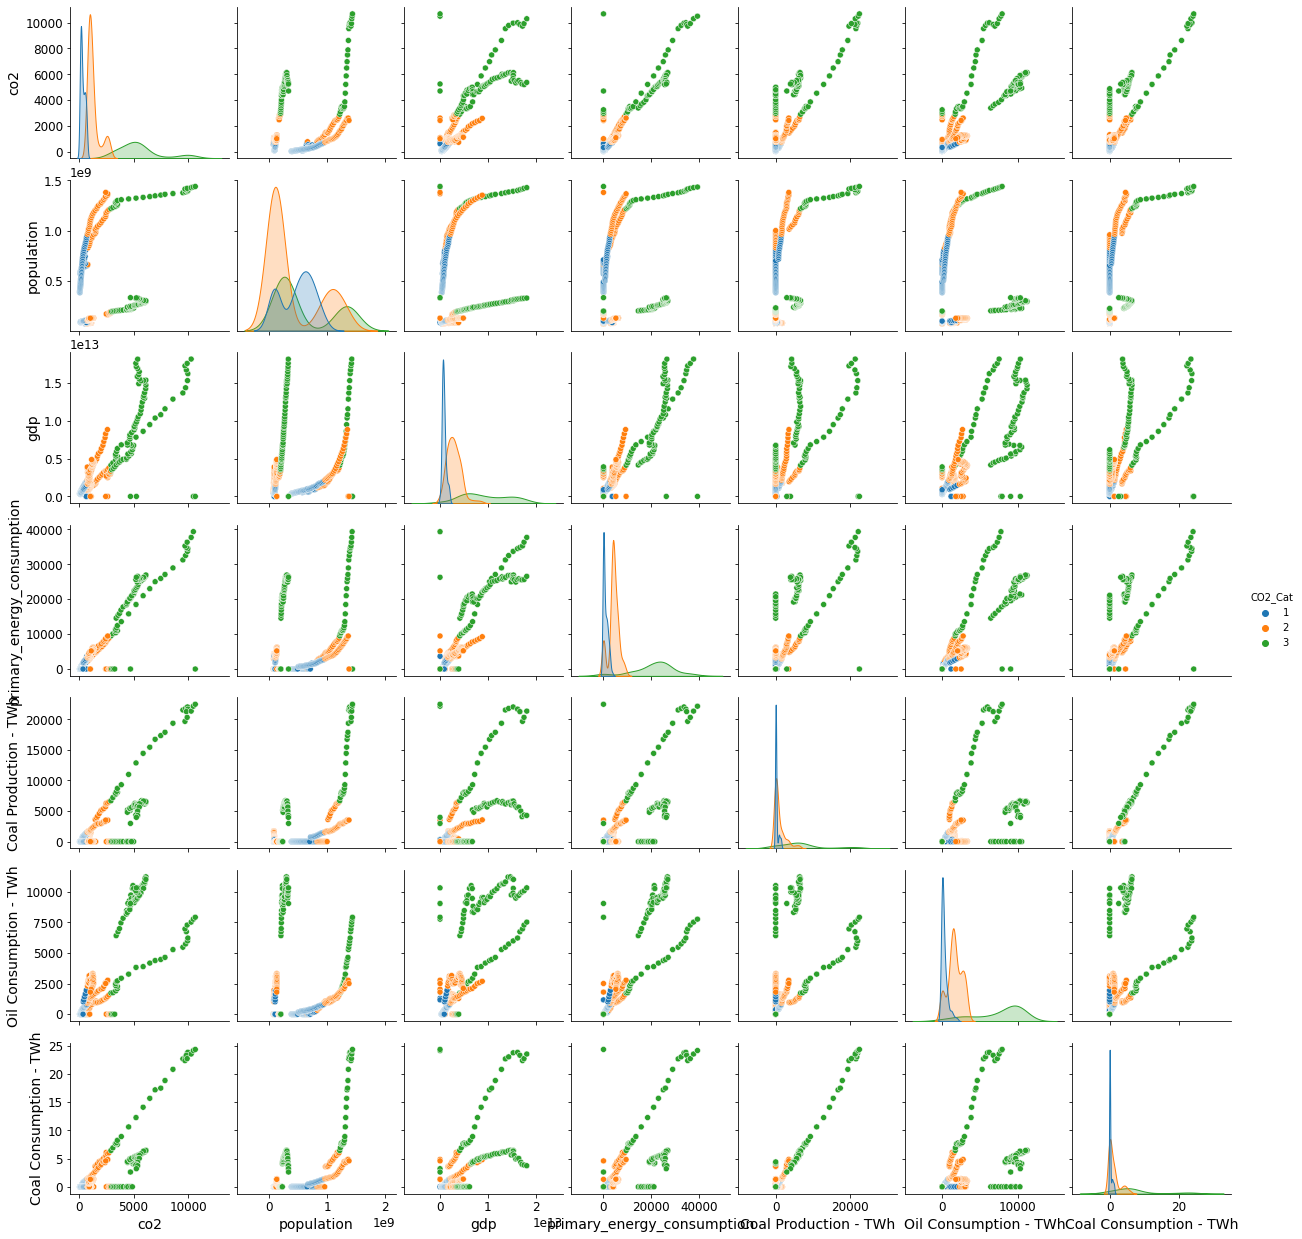

In [43]:
sns.pairplot(option_4, hue='CO2_Cat', vars=["co2","population","gdp","primary_energy_consumption","Coal Production - TWh","Oil Consumption - TWh","Coal Consumption - TWh"]);

#### Generating scatter plots between variables

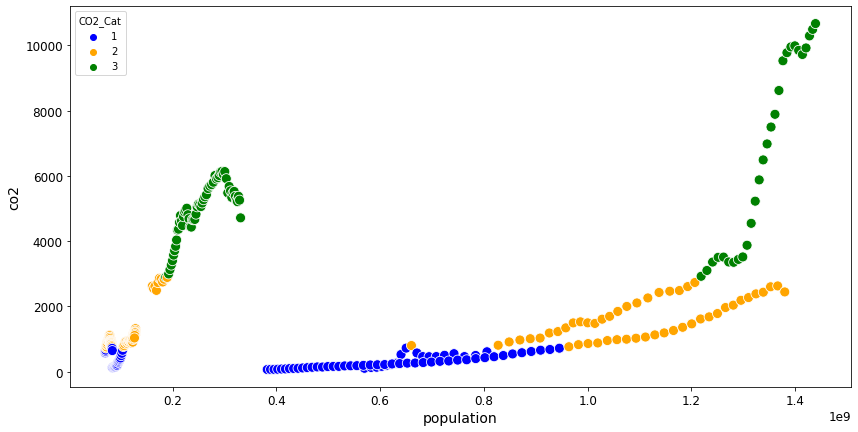

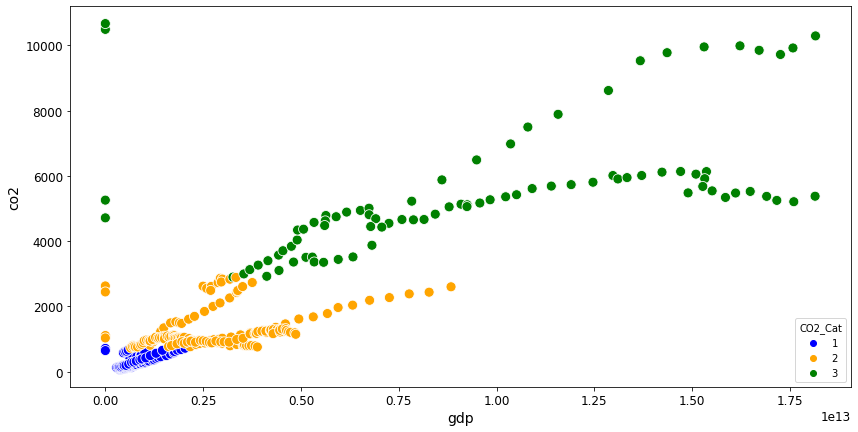

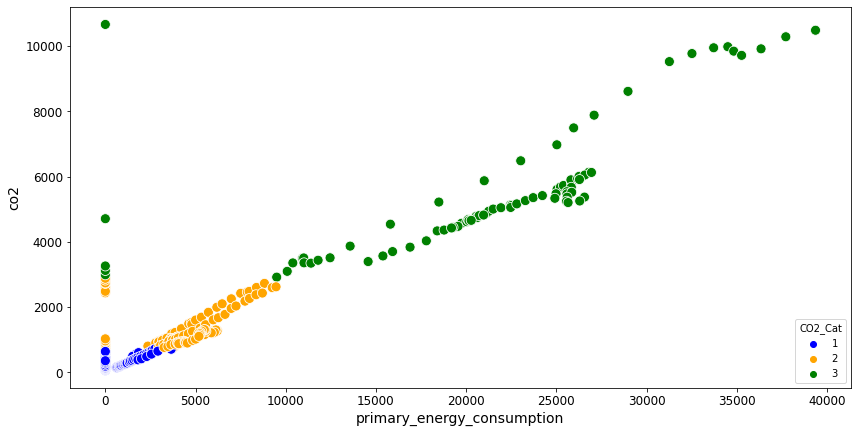

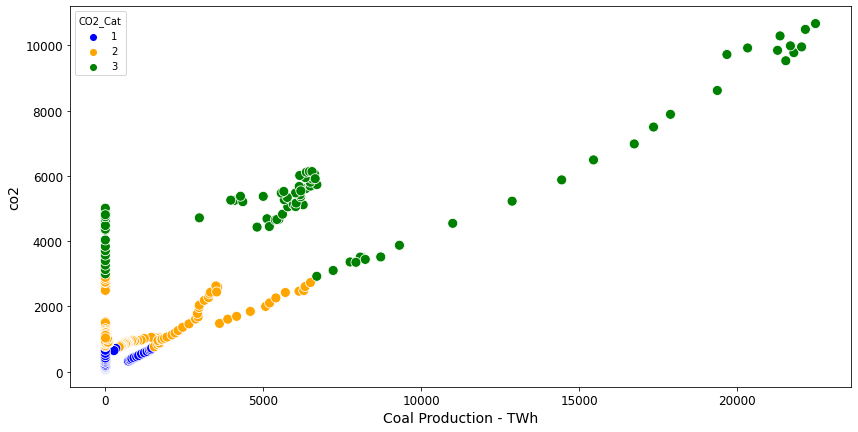

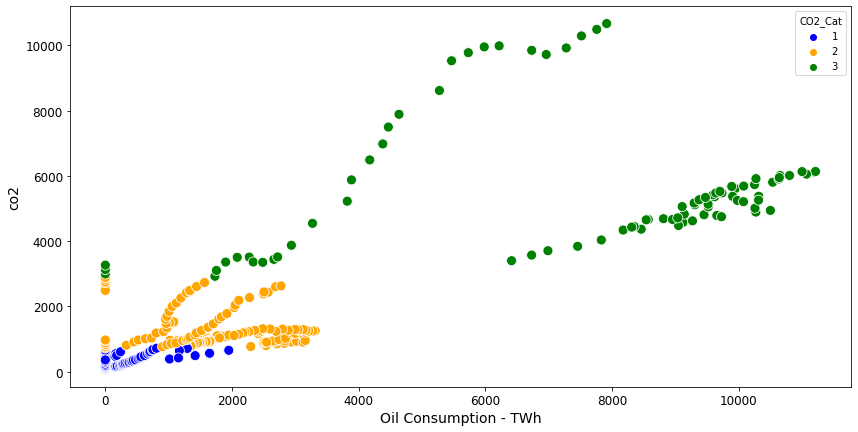

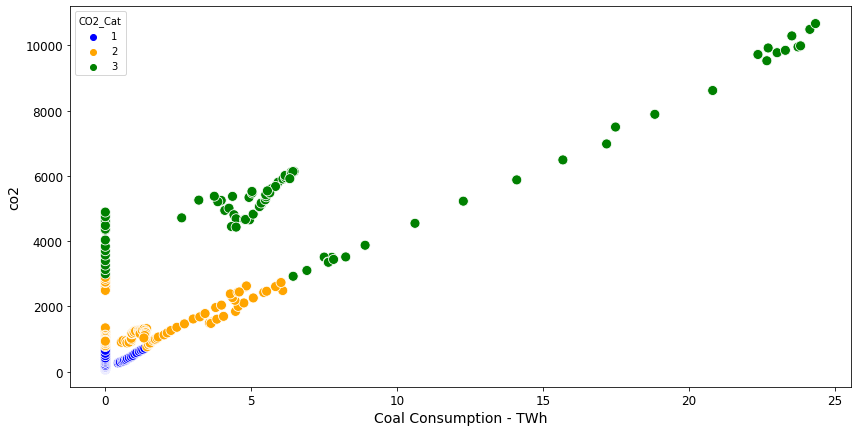

In [44]:
features = ['population', 'gdp', 'primary_energy_consumption', \
          'Coal Production - TWh', 'Oil Consumption - TWh', 'Coal Consumption - TWh']

for i in features:
    fig, ax = plt.subplots(figsize=(14,7))
    ax=sns.scatterplot(y='co2', x =i, hue='CO2_Cat',
                      palette= {1:"blue", 2: "orange", 3:"green"},
                      data=option_4, legend='full', s=100)

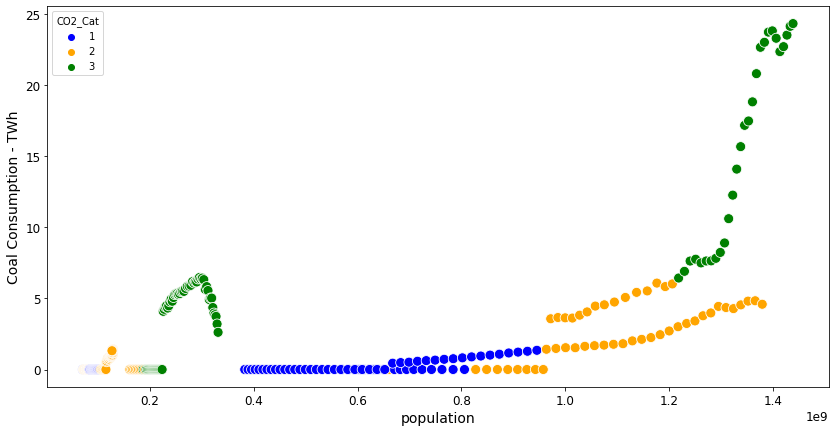

In [45]:
## Population and "Coal Consumption - TWh"

fig, ax = plt.subplots(figsize=(14,7))
ax=sns.scatterplot(y='Coal Consumption - TWh', x ="population", hue='CO2_Cat',
                  palette= {1:"blue", 2: "orange", 3:"green"},
                  data=option_4, legend='full', s=100)

#### Plotting features against Categories

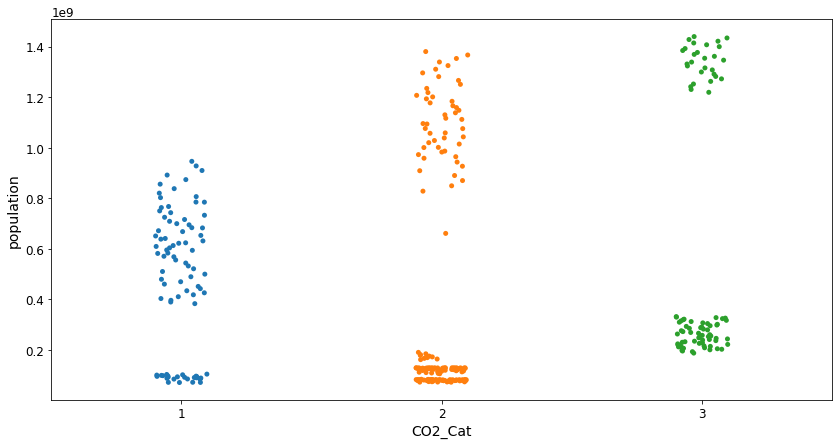

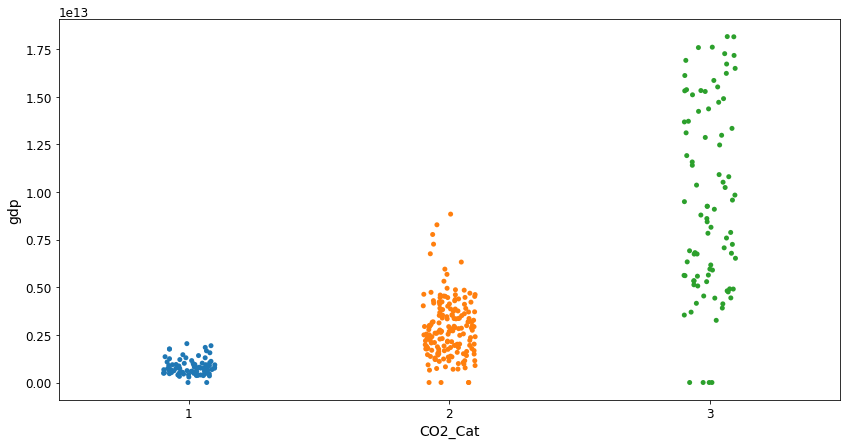

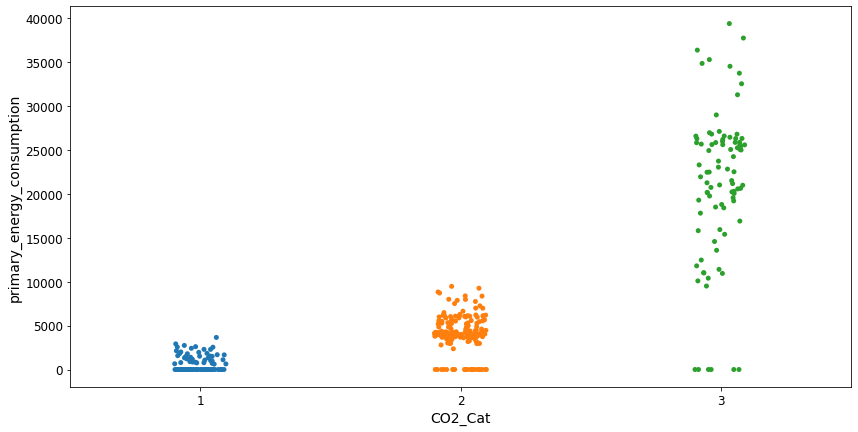

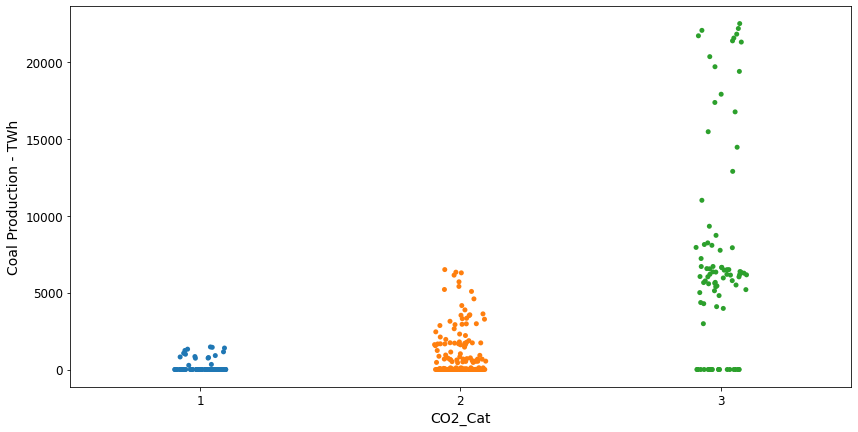

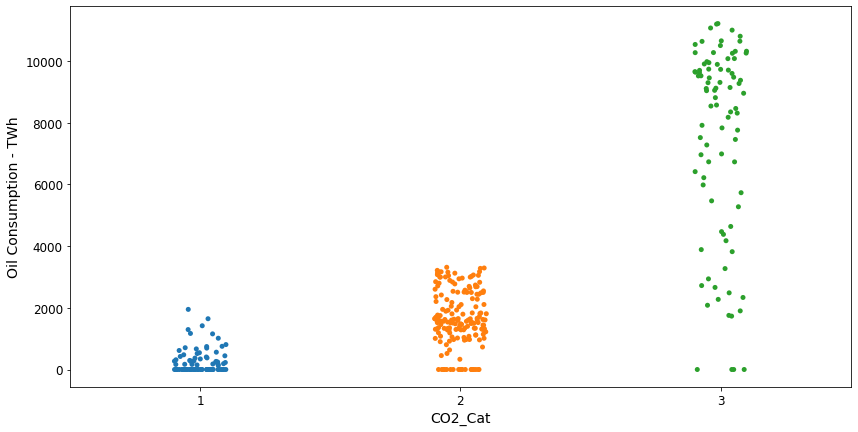

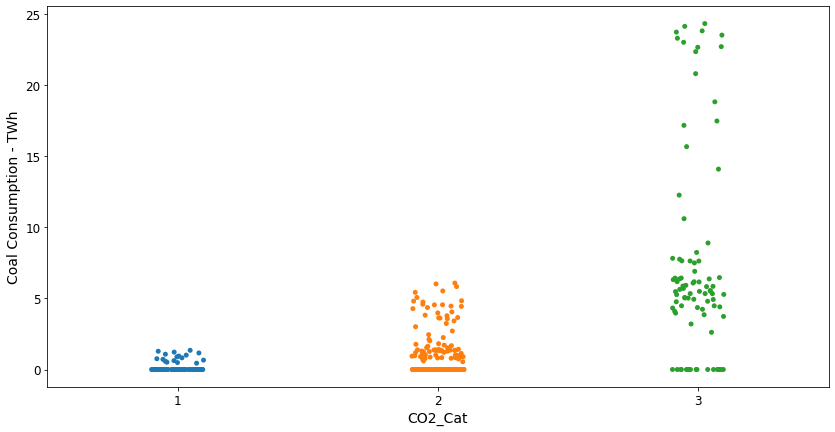

In [46]:
features = ['population', 'gdp', 'primary_energy_consumption', \
          'Coal Production - TWh', 'Oil Consumption - TWh', 'Coal Consumption - TWh']

for i in features:
    fig, ax = plt.subplots(figsize=(14,7))
    sns.stripplot(x="CO2_Cat", y=i, data=option_4);

In [47]:
datadrop = option_4.loc[option_4["Cars Produced - Thousands"]=="U"]
option_4 = option_4.drop(datadrop.index)

X = option_4.drop(["country","index","year","co2","Target_Rank","CO2_Cat"],axis=1)
colnames= X.columns
X = option_4.drop(["country","index","year","co2","Target_Rank","CO2_Cat"],axis=1).values
y = option_4["co2"].values

In [48]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

## K-Means Clustering

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Using Elbow Method to find optimal number of clusters

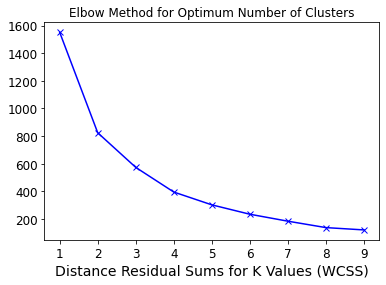

In [50]:
# Elbow
kmeans = KMeans()
ssd = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(x_train)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

#### Inspect Elbow Method further by generating silhouette score

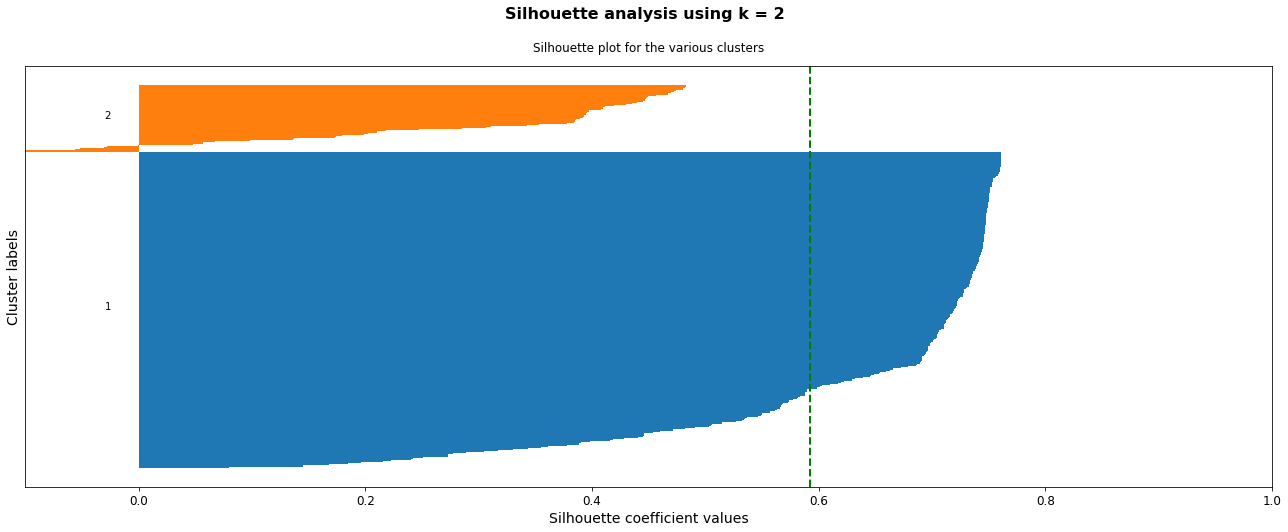

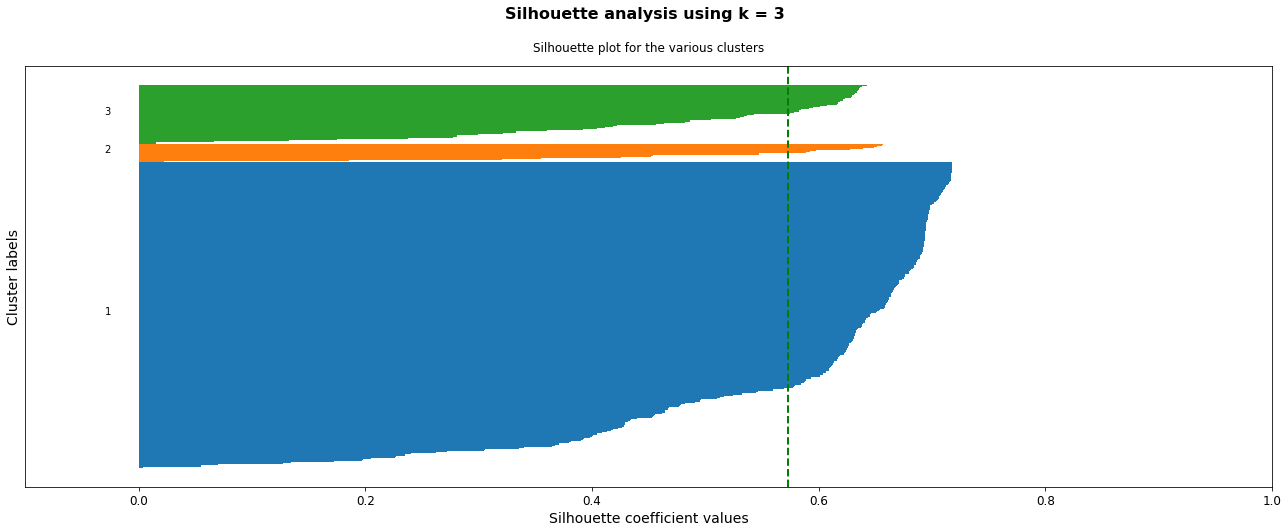

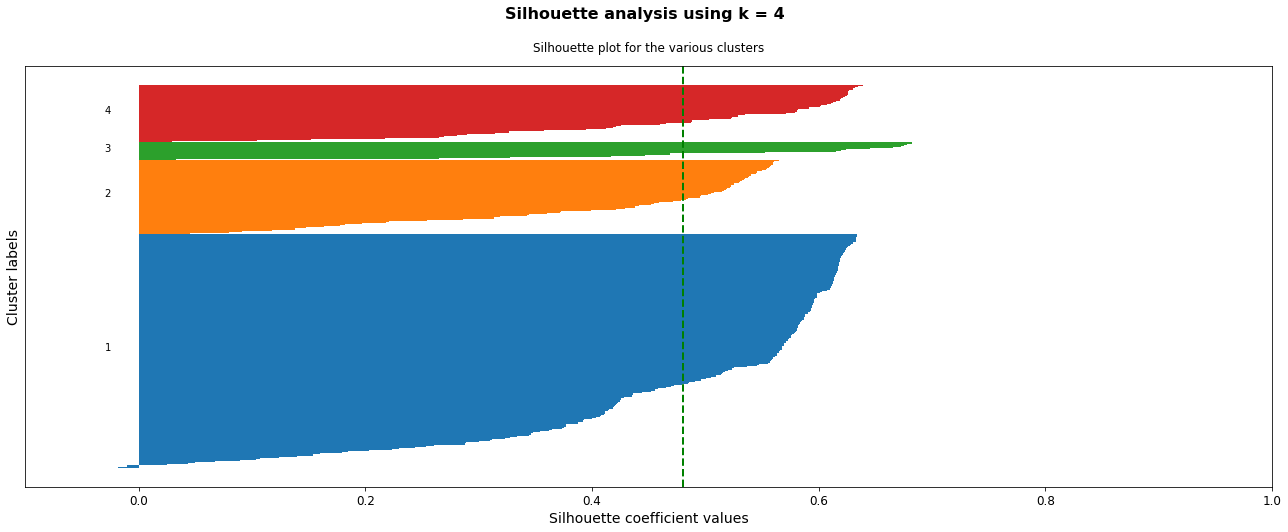

In [51]:
## silhouette score
from sklearn.metrics import silhouette_samples, silhouette_score

for i, k in enumerate([2, 3, 4]):
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

<div class="alert alert-block alert-success"><b>Silhouette Analysis Shows good results on both 3 and 4 clusters</b>

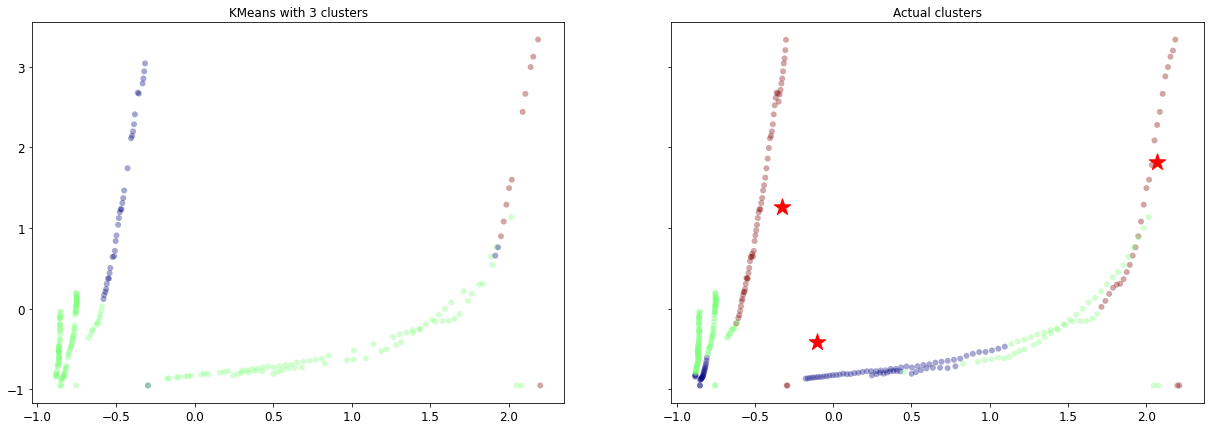

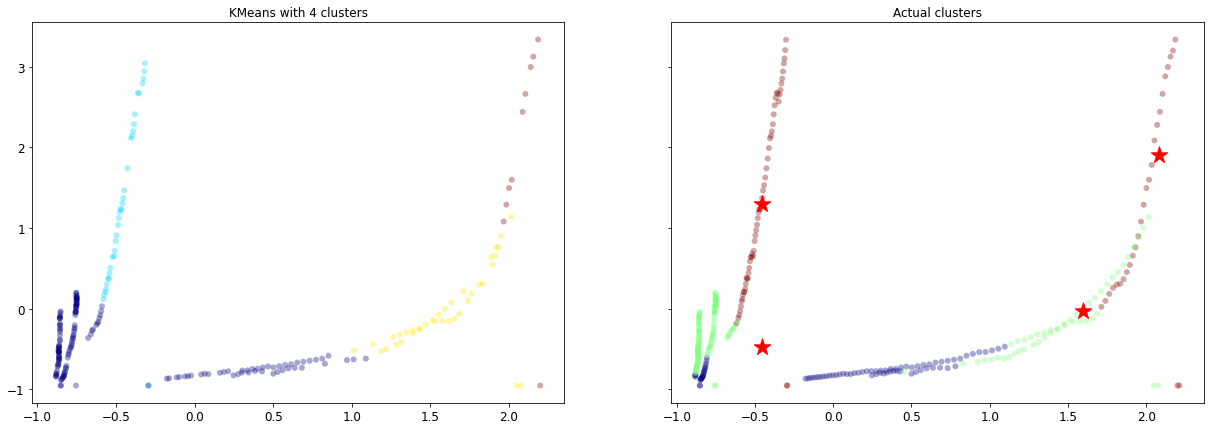

In [52]:
# KMeans for 3 & 4 Clusters
for i in range(3,5):
    kmns = KMeans(n_clusters=i, init='k-means++', n_init=40, max_iter=100, tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='auto')
    kY = kmns.fit_predict(x_train)
    centroids = kmns.cluster_centers_

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(21,7))

    ax1.scatter(x_train[:,0],x_train[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
    ax1.set_title(f'KMeans with {i} clusters')

    ax2.scatter(X[:,0],X[:,1],  c = option_4['CO2_Cat'], cmap = "jet", edgecolor = "None", alpha=0.35)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
                c='r', label='centroid')
    ax2.set_title('Actual clusters');

##### Using 80-20 split to see if results are different

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

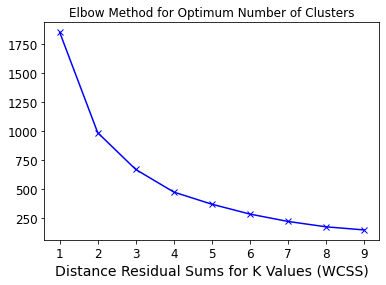

In [54]:
# Elbow
kmeans = KMeans()
ssd = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(x_train)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

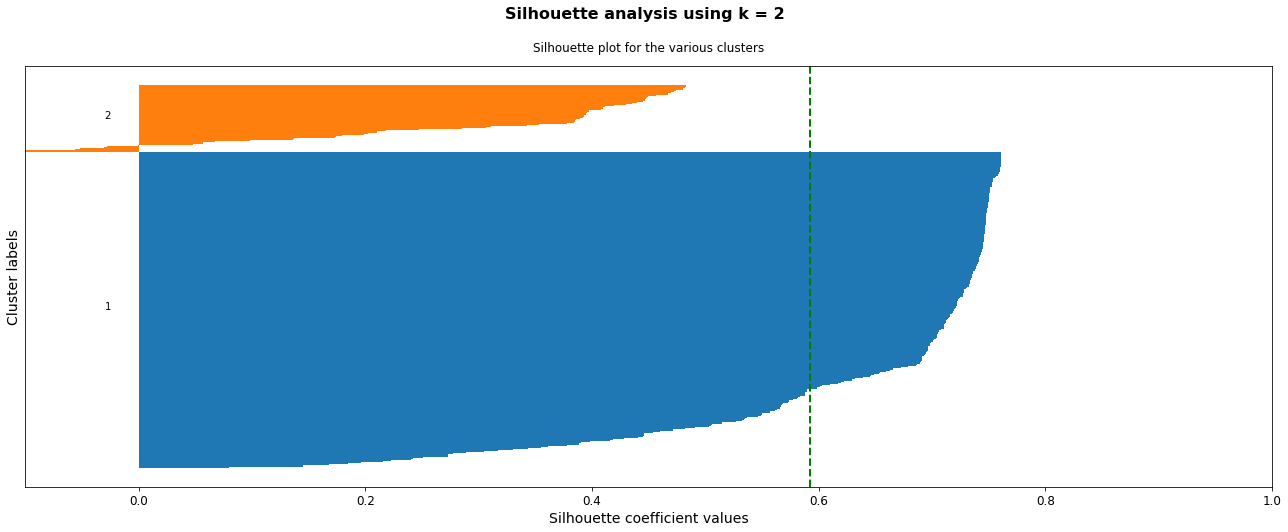

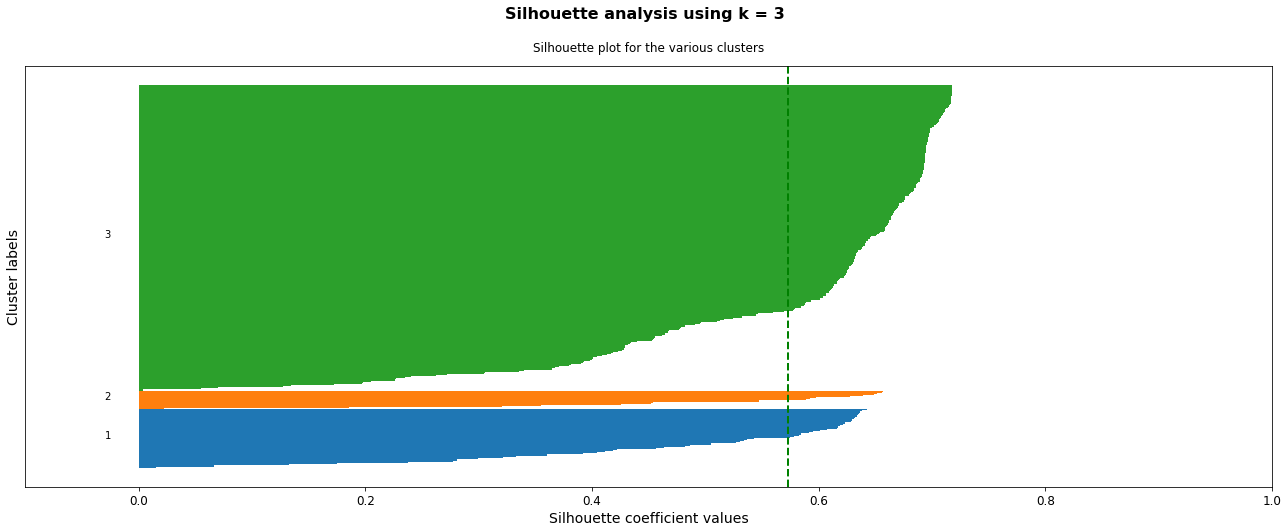

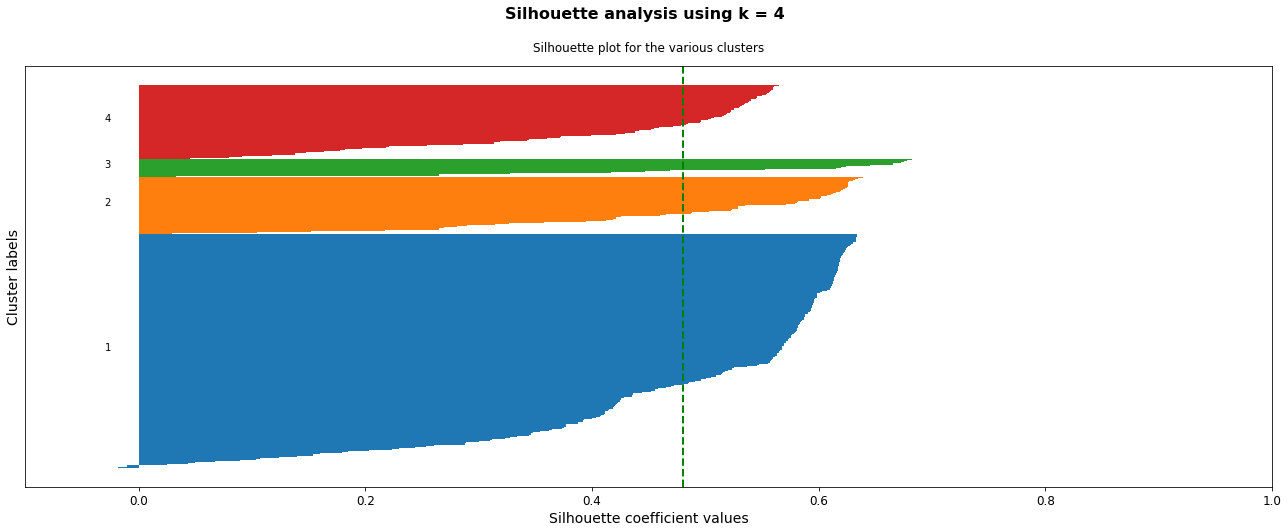

In [55]:
from sklearn.metrics import silhouette_samples, silhouette_score

for i, k in enumerate([2, 3, 4]):
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}', fontsize=16, fontweight='semibold', y=1.05);

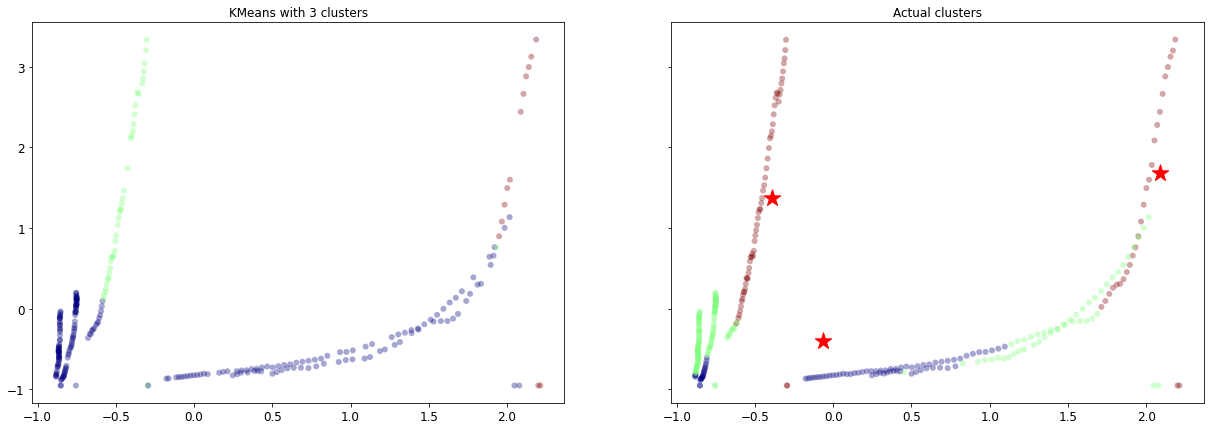

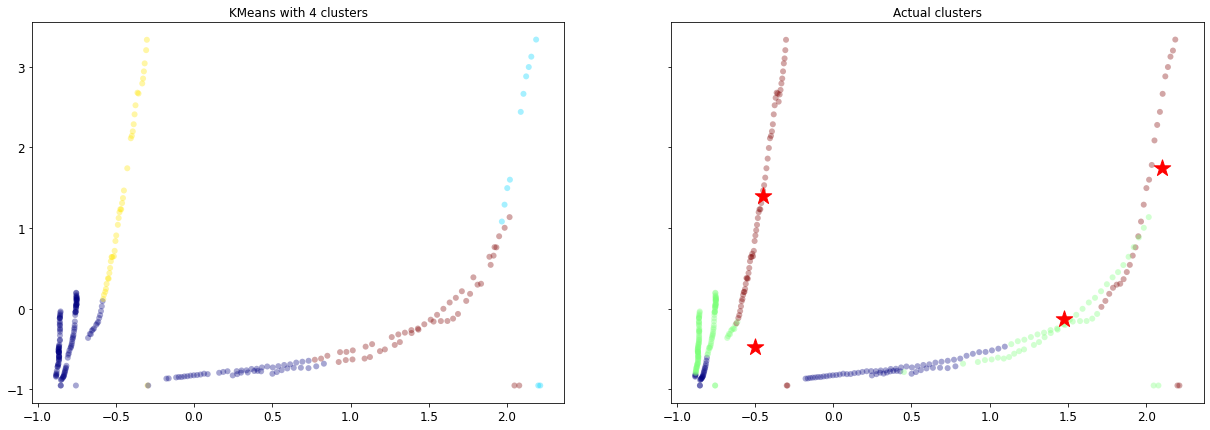

In [56]:
# KMeans for 3 & 4 Clusters
for i in range(3,5):
    kmns = KMeans(n_clusters=i, init='k-means++', n_init=40, max_iter=100, tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='auto')
    kY = kmns.fit_predict(x_train)
    centroids = kmns.cluster_centers_

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(21,7))

    ax1.scatter(x_train[:,0],x_train[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
    ax1.set_title(f'KMeans with {i} clusters')

    ax2.scatter(X[:,0],X[:,1],  c = option_4['CO2_Cat'], cmap = "jet", edgecolor = "None", alpha=0.35)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
                c='r', label='centroid')
    ax2.set_title('Actual clusters');

## Lasso

In [57]:
from sklearn.linear_model import Lasso

alpha_levels = [1.0, 0.5, 0.2, 0.1]

for i in alpha_levels:
    lasso = Lasso(normalize=True, alpha = i)
    lasso.fit(x_train,y_train)
    coeff_df = pd.DataFrame(lasso.coef_, colnames, columns=['Coefficient'])  
    display(coeff_df)
    print(f'Alpha level: {i}')
    
    score_model(lasso, x_train, y_train, x_test, y_test)
    
    ## Cross validation Scoring, 10-fold
    cv_scores = cross_val_score(lasso, X, y, cv = 10)
    print()
    print("#### Cross validation Scoring, 10-fold ####")
    print(cv_scores)
    print(f'Average 10-Fold CV Score: {np.mean(cv_scores):.4f}')

,Coefficient
population,-75.886620
gdp,92.028089
primary_energy_consumption,127.641385
Coal Production - TWh,474.105685
Oil Consumption - TWh,982.183800
Coal Consumption - TWh,922.638348
Cars Produced - Thousands,-30.973693


Alpha level: 1.0
#### Training dataset scores ####
The intercept for model is 2115.6225
Mean Absolute Error: 379.375752
Mean Squared Error: 366693.972416
Root Mean Squared Error: 605.552617
R2 score: 0.926777

#### Testing dataset scores ####
The intercept for model is 2115.6225
Mean Absolute Error: 314.240730
Mean Squared Error: 234361.766496
Root Mean Squared Error: 484.109251
R2 score: 0.960135

#### Cross validation Scoring, 10-fold ####
[ 0.78772396  0.47144807 -2.72022957 -0.17338924 -9.53795666  0.73285641
 -2.63944956 -4.56410675 -3.24459412 -0.48585132]
Average 10-Fold CV Score: -2.1374


,Coefficient
population,-117.834734
gdp,118.308160
primary_energy_consumption,99.041677
Coal Production - TWh,440.723502
Oil Consumption - TWh,986.353293
Coal Consumption - TWh,1028.513170
Cars Produced - Thousands,-84.029248


Alpha level: 0.5
#### Training dataset scores ####
The intercept for model is 2116.1235
Mean Absolute Error: 376.959054
Mean Squared Error: 362546.779278
Root Mean Squared Error: 602.118576
R2 score: 0.927605

#### Testing dataset scores ####
The intercept for model is 2116.1235
Mean Absolute Error: 306.641415
Mean Squared Error: 230184.803907
Root Mean Squared Error: 479.775785
R2 score: 0.960845

#### Cross validation Scoring, 10-fold ####
[ 0.74255019  0.47448288 -2.072482    0.0319522  -8.38380861  0.80572412
 -3.19090322 -4.68150923 -3.21763855 -0.75050813]
Average 10-Fold CV Score: -2.0242


,Coefficient
population,-142.999281
gdp,134.079216
primary_energy_consumption,81.837764
Coal Production - TWh,420.808717
Oil Consumption - TWh,988.885940
Coal Consumption - TWh,1091.934313
Cars Produced - Thousands,-115.856768


Alpha level: 0.2
#### Training dataset scores ####
The intercept for model is 2116.4244
Mean Absolute Error: 375.883492
Mean Squared Error: 361384.505848
Root Mean Squared Error: 601.152648
R2 score: 0.927837

#### Testing dataset scores ####
The intercept for model is 2116.4244
Mean Absolute Error: 302.567439
Mean Squared Error: 228650.065967
Root Mean Squared Error: 478.173678
R2 score: 0.961106

#### Cross validation Scoring, 10-fold ####
[ 0.71170733  0.49026557 -1.76140086  0.15783214 -7.7291744   0.84503795
 -3.54547669 -4.7856694  -3.20212152 -0.9332217 ]
Average 10-Fold CV Score: -1.9752


,Coefficient
population,-151.387459
gdp,139.336235
primary_energy_consumption,76.103090
Coal Production - TWh,414.170573
Oil Consumption - TWh,989.730183
Coal Consumption - TWh,1113.074585
Cars Produced - Thousands,-126.465935


Alpha level: 0.1
#### Training dataset scores ####
The intercept for model is 2116.5247
Mean Absolute Error: 375.683417
Mean Squared Error: 361218.034818
Root Mean Squared Error: 601.014172
R2 score: 0.927871

#### Testing dataset scores ####
The intercept for model is 2116.5247
Mean Absolute Error: 301.209455
Mean Squared Error: 228299.851221
Root Mean Squared Error: 477.807337
R2 score: 0.961166

#### Cross validation Scoring, 10-fold ####
[ 0.70080956  0.49548748 -1.67060842  0.19650369 -7.51727372  0.85620079
 -3.66760864 -4.80493959 -3.19702174 -0.99815652]
Average 10-Fold CV Score: -1.9607


#### Plot below shows Oil Consumption and Coal Consuption are two very important variables that can drive CO2 emission

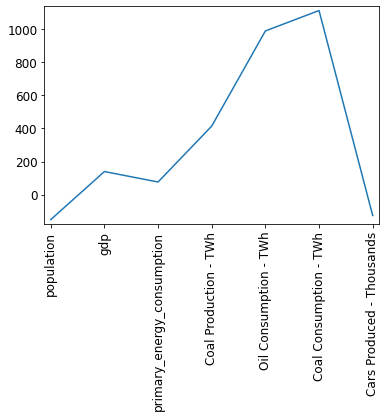

In [58]:
# Plot the coefficients
plt.plot(range(len(colnames)), lasso.coef_);
plt.xticks(range(len(colnames)), colnames.values, rotation=90);
plt.margins(0.02)
plt.show()

### Ridge

In [59]:
alpha_levels = [1.0, 0.5, 0.2, 0.1]

for i in alpha_levels:
    ridge = linear_model.Ridge(alpha = i)
    ridge.fit(x_train,y_train)
    coeff_df = pd.DataFrame(ridge.coef_, colnames, columns=['Coefficient'])  
    display(coeff_df)
    print(f'Alpha level: {i}')
    
    score_model(ridge, x_train, y_train, x_test, y_test)
    
    ## Cross validation Scoring, 10-fold
    cv_scores = cross_val_score(ridge, X, y, cv = 10)
    print()
    print("#### Cross validation Scoring, 10-fold ####")
    print(cv_scores)
    print(f'Average 10-Fold CV Score: {np.mean(cv_scores)}')

,Coefficient
population,-151.118357
gdp,136.574752
primary_energy_consumption,111.112758
Coal Production - TWh,467.224868
Oil Consumption - TWh,964.693505
Coal Consumption - TWh,1042.908068
Cars Produced - Thousands,-121.272296


Alpha level: 1.0
#### Training dataset scores ####
The intercept for model is 2117.0069
Mean Absolute Error: 377.763853
Mean Squared Error: 361497.019869
Root Mean Squared Error: 601.246222
R2 score: 0.927815

#### Testing dataset scores ####
The intercept for model is 2117.0069
Mean Absolute Error: 303.756264
Mean Squared Error: 228104.427202
Root Mean Squared Error: 477.602792
R2 score: 0.961199

#### Cross validation Scoring, 10-fold ####
[ 0.70376792  0.511706   -1.73139985  0.10112835 -7.53675717  0.85904988
 -3.45162693 -4.37292065 -3.19781439 -1.05789812]
Average 10-Fold CV Score: -1.9172764969502922


,Coefficient
population,-155.234059
gdp,140.116495
primary_energy_consumption,92.124681
Coal Production - TWh,439.933984
Oil Consumption - TWh,976.916126
Coal Consumption - TWh,1085.138361
Cars Produced - Thousands,-128.702402


Alpha level: 0.5
#### Training dataset scores ####
The intercept for model is 2116.8303
Mean Absolute Error: 376.532494
Mean Squared Error: 361258.642928
Root Mean Squared Error: 601.047954
R2 score: 0.927863

#### Testing dataset scores ####
The intercept for model is 2116.8303
Mean Absolute Error: 301.947934
Mean Squared Error: 228043.689861
Root Mean Squared Error: 477.539202
R2 score: 0.961209

#### Cross validation Scoring, 10-fold ####
[ 0.69726898  0.50675965 -1.66163936  0.16494142 -7.42694848  0.86272205
 -3.60860549 -4.50544474 -3.19420809 -1.06075573]
Average 10-Fold CV Score: -1.9225909799240213


,Coefficient
population,-157.949150
gdp,142.639127
primary_energy_consumption,79.955607
Coal Production - TWh,419.894275
Oil Consumption - TWh,984.560315
Coal Consumption - TWh,1114.819792
Cars Produced - Thousands,-133.661808


Alpha level: 0.2
#### Training dataset scores ####
The intercept for model is 2116.7073
Mean Absolute Error: 375.851287
Mean Squared Error: 361178.816133
Root Mean Squared Error: 600.981544
R2 score: 0.927879

#### Testing dataset scores ####
The intercept for model is 2116.7073
Mean Absolute Error: 300.638196
Mean Squared Error: 227992.990801
Root Mean Squared Error: 477.486116
R2 score: 0.961218

#### Cross validation Scoring, 10-fold ####
[ 0.69300281  0.50284288 -1.61469945  0.20718296 -7.35747343  0.86500763
 -3.71641131 -4.60556639 -3.19174295 -1.05912804]
Average 10-Fold CV Score: -1.9276985299201708


,Coefficient
population,-158.903617
gdp,143.556859
primary_energy_consumption,75.759968
Coal Production - TWh,412.465332
Oil Consumption - TWh,987.160222
Coal Consumption - TWh,1125.592708
Cars Produced - Thousands,-135.414774


Alpha level: 0.1
#### Training dataset scores ####
The intercept for model is 2116.6629
Mean Absolute Error: 375.636577
Mean Squared Error: 361166.147287
Root Mean Squared Error: 600.971004
R2 score: 0.927881

#### Testing dataset scores ####
The intercept for model is 2116.6629
Mean Absolute Error: 300.153917
Mean Squared Error: 227973.697403
Root Mean Squared Error: 477.465912
R2 score: 0.961221

#### Cross validation Scoring, 10-fold ####
[ 0.69150317  0.50133611 -1.59811603  0.22201253 -7.33363043  0.86578594
 -3.75506406 -4.64324144 -3.1908534  -1.05785132]
Average 10-Fold CV Score: -1.929811892120671


### ElasticNet

In [60]:
from sklearn.linear_model import ElasticNet

alpha_levels = [1.0, 0.5, 0.2, 0.1]

for i in alpha_levels:
    elastic = ElasticNet(random_state=42, alpha = i)
    elastic.fit(x_train, y_train)
    coeff_df = pd.DataFrame(elastic.coef_, colnames, columns=['Coefficient'])  
    display(coeff_df)
    print(f'Alpha level: {i}')
    
    score_model(elastic, x_train, y_train, x_test, y_test)

,Coefficient
population,44.997775
gdp,269.428376
primary_energy_consumption,436.392767
Coal Production - TWh,435.781541
Oil Consumption - TWh,495.529442
Coal Consumption - TWh,440.492214
Cars Produced - Thousands,147.288766


Alpha level: 1.0
#### Training dataset scores ####
The intercept for model is 2114.0915
Mean Absolute Error: 507.466085
Mean Squared Error: 508278.511734
Root Mean Squared Error: 712.936541
R2 score: 0.898505

#### Testing dataset scores ####
The intercept for model is 2114.0915
Mean Absolute Error: 408.376049
Mean Squared Error: 303235.191164
Root Mean Squared Error: 550.667950
R2 score: 0.948419


,Coefficient
population,3.440063
gdp,228.951645
primary_energy_consumption,448.489002
Coal Production - TWh,498.007705
Oil Consumption - TWh,583.621478
Coal Consumption - TWh,514.851448
Cars Produced - Thousands,92.108555


Alpha level: 0.5
#### Training dataset scores ####
The intercept for model is 2117.0965
Mean Absolute Error: 438.840906
Mean Squared Error: 436348.875917
Root Mean Squared Error: 660.567087
R2 score: 0.912868

#### Testing dataset scores ####
The intercept for model is 2117.0965
Mean Absolute Error: 351.700674
Mean Squared Error: 253938.296520
Root Mean Squared Error: 503.922907
R2 score: 0.956805


,Coefficient
population,-56.353171
gdp,164.892607
primary_energy_consumption,407.774942
Coal Production - TWh,563.083811
Oil Consumption - TWh,700.373244
Coal Consumption - TWh,624.934866
Cars Produced - Thousands,15.746405


Alpha level: 0.2
#### Training dataset scores ####
The intercept for model is 2118.3545
Mean Absolute Error: 398.948227
Mean Squared Error: 390832.322808
Root Mean Squared Error: 625.165836
R2 score: 0.921957

#### Testing dataset scores ####
The intercept for model is 2118.3545
Mean Absolute Error: 326.088147
Mean Squared Error: 232645.804807
Root Mean Squared Error: 482.333707
R2 score: 0.960426


,Coefficient
population,-92.906208
gdp,134.673238
primary_energy_consumption,338.570915
Coal Production - TWh,584.290568
Oil Consumption - TWh,785.205266
Coal Consumption - TWh,716.456955
Cars Produced - Thousands,-31.366263


Alpha level: 0.1
#### Training dataset scores ####
The intercept for model is 2118.3188
Mean Absolute Error: 389.923823
Mean Squared Error: 375047.048912
Root Mean Squared Error: 612.410850
R2 score: 0.925109

#### Testing dataset scores ####
The intercept for model is 2118.3188
Mean Absolute Error: 318.044145
Mean Squared Error: 228647.881199
Root Mean Squared Error: 478.171393
R2 score: 0.961106


### Random Forest Regressor

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# param_grid = {
#                  'n_estimators': [5, 10, 15, 20, 100, 250, 500, 750, 1000],
#                  'max_depth': [2, 5, 7, 9, 50, 100, 1000]
#              }

forest = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=9, n_estimators=500)

# grid = GridSearchCV(forest, param_grid, cv=10, n_jobs=-1)
# grid.fit(x_train, y_train)

forest.fit(x_train, y_train)

score_model(forest, x_train, y_train, x_test, y_test)

# Cross validation Scoring, 10-fold
cv_scores = cross_val_score(forest, X, y, cv = 10)
print()
print("#### Cross validation Scoring, 10-fold ####")
print(cv_scores)
print(f'Average 10-Fold CV Score: {np.mean(cv_scores)}')

# # Print best params from GridSearchCV
# print()
# print(f'Best Params: {grid.best_params_}')

#### Training dataset scores ####
Mean Absolute Error: 38.493627
Mean Squared Error: 15818.484757
Root Mean Squared Error: 125.771558
R2 score: 0.996841

#### Testing dataset scores ####
Mean Absolute Error: 75.911415
Mean Squared Error: 17318.009044
Root Mean Squared Error: 131.597907
R2 score: 0.997054

#### Cross validation Scoring, 10-fold ####
[ 0.80476704  0.2193659  -1.31665272  0.32078548 -1.05090854  0.05417831
  0.78506656 -0.90874898  0.53012186 -0.26092554]
Average 10-Fold CV Score: -0.08229506211825632
